1. Instalações

In [1]:
%pip install pandas numpy scikit-learn imbalanced-learn xgboost lightgbm catboost optuna python-docx

Note: you may need to restart the kernel to use updated packages.


2. Importações

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, mutual_info_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import optuna
from docx import Document
import matplotlib.pyplot as plt
import seaborn as sns

3. Funções gerais

In [3]:
def load_data(path: str, sep: str = ';') -> pd.DataFrame:
    """Carrega um CSV do caminho dado e limpa espaços no nome das colunas."""
    df = pd.read_csv(path, sep=sep, low_memory=False)
    df.columns = df.columns.str.strip()
    return df

def normalize_features(df: pd.DataFrame, features: list) -> pd.DataFrame:
    """Aplica StandardScaler às colunas listadas."""
    scaler = StandardScaler()
    df_norm = df.copy()
    df_norm[features] = scaler.fit_transform(df[features])
    return df_norm

def balance_classes(df: pd.DataFrame, target: str, n_samples: int = 30000,
                    random_state: int = 42) -> pd.DataFrame:
    """Sobreamostra cada classe para ter exatamente n_samples."""
    df0 = df[df[target] == 0]
    df1 = df[df[target] == 1]
    df0_res = df0.sample(n=n_samples, random_state=random_state)
    df1_res = df1.sample(n=n_samples, random_state=random_state)
    return pd.concat([df0_res, df1_res]).reset_index(drop=True)

def evaluate_models(models: dict, X: pd.DataFrame, y: pd.Series,
                    cv: int = 10) -> tuple[pd.DataFrame, dict]:
    """Roda CV estratificado e retorna DataFrame de métricas + dicionário de ROC curves."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    metrics_list, roc_curves = [], {}
    for name, model in models.items():
        y_pred = cross_val_predict(model, X, y, cv=skf)
        if hasattr(model, "predict_proba"):
            y_proba = cross_val_predict(model, X, y, cv=skf, method="predict_proba")[:,1]
        else:
            y_proba = None

        metrics_list.append({
            "model": name,
            "accuracy": accuracy_score(y, y_pred),
            "precision": precision_score(y, y_pred),
            "recall": recall_score(y, y_pred),
            "f1": f1_score(y, y_pred),
            "roc_auc": roc_auc_score(y, y_proba) if y_proba is not None else np.nan,
            "mutual_info": mutual_info_score(y, y_pred)
        })

        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y, y_proba)
            roc_curves[name] = (fpr, tpr)

    return pd.DataFrame(metrics_list), roc_curves

def plot_roc_curves(roc_curves: dict, save_path: str):
    """Plota e salva comparativo de todas as curvas ROC."""
    plt.figure()
    for name,(fpr,tpr) in roc_curves.items():
        plt.plot(fpr,tpr,label=name)
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def plot_metrics_bar(metrics_df: pd.DataFrame, metric: str, save_path: str):
    """Plota e salva gráfico de barras comparando uma métrica."""
    plt.figure()
    metrics_df.set_index("model")[metric].sort_values().plot.bar()
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric}")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def save_metrics(metrics_df: pd.DataFrame, output_dir: str, filename: str):
    """Salva o DataFrame de métricas como CSV."""
    os.makedirs(output_dir, exist_ok=True)
    metrics_df.to_csv(os.path.join(output_dir, filename), index=False)

def run_optuna(models: dict, X: pd.DataFrame, y: pd.Series, n_trials_dict: dict) -> dict:
    """Executa Optuna para cada modelo, otimizando F1; retorna dict model_name→best_params."""
    best_params = {}
    for name, model in models.items():
        def objective(trial):
            # Exemplo: ajusta C para LogisticRegression
            if name=="LogisticRegression":
                model.set_params(C=trial.suggest_loguniform("C",1e-5,1e2))
            # TODO: completar espaços de busca para os demais modelos...
            y_pred = cross_val_predict(model, X, y, cv=StratifiedKFold(10,True,42))
            return f1_score(y, y_pred)

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials_dict.get(name, 30))
        best_params[name] = study.best_params
    return best_params

def generate_report(report_path: str, orig_dir: str, opt_dir: str):
    """Monta um .docx com tabelas e plots dos diretórios informado."""
    doc = Document()
    doc.add_heading("Relatório do Pipeline", level=1)

    for title, d in [("Modelos Originais", orig_dir), ("Modelos Otimizados", opt_dir)]:
        doc.add_heading(title, level=2)
        for fname in sorted(os.listdir(d)):
            path = os.path.join(d, fname)
            if fname.endswith(".csv"):
                df = pd.read_csv(path)
                doc.add_heading(fname, level=3)
                table = doc.add_table(rows=1, cols=len(df.columns))
                hdr=table.rows[0].cells
                for i,col in enumerate(df.columns):
                    hdr[i].text=col
                for _,row in df.iterrows():
                    cells=table.add_row().cells
                    for i,v in enumerate(row): cells[i].text=str(v)
            elif fname.endswith(".png"):
                doc.add_heading(fname, level=3)
                doc.add_picture(path, width=docx.shared.Inches(6))

    doc.save(report_path)

4. Carregamento e pré-processamento

In [4]:
# 4.1 Definição da função de pré-processamento
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """ Pré-processamento dos dados."""
    # Cria uma cópia dos registros originais
    df['RegistroOriginal'] = df['Registro']

    # Substitui os registros repetidos pelo primeiro registro do grupo
    df['Registro'] = df.groupby('NomePaciente')['Registro'].transform('first')

    # Verifica quais pacientes tiveram o Registro alterado
    df[df['Registro'] != df['RegistroOriginal']]

    # legenda
    mapa_cor = {
    1: 'AMARELO',
    2: 'VERMELHO',
    3: 'ÂMBAR',
    4: 'ALARANJADO',
    5: 'VERDE',
    6: 'AZUL'
}

    # converte, mapeia e mantém valores não mapeados
    df['COR'] = (pd.to_numeric(df['COR'], errors='coerce')
               .astype('Int64')
               .map(mapa_cor)
               .fillna(df['COR']))
    # lista das colunas para imputar 0
    cols_zero = [
        'FOSF_CA', 'BYST', 'DISMOR', 'CIL_LEUC', 'CIL_HEMAT', 'BROAD',
        'CIL_GRAXO', 'HEMAC', 'HYAL', 'GRAN', 'URT_AMRF', 'FSF_AMRF',
        'CIL_CEROSOS'
    ]

    # Tratar strings vazias como missing e preencher com 0
    for c in cols_zero:
        if c in df.columns:
            df[c] = (pd.to_numeric(df[c], errors='coerce')  # caso sejam numéricas
                    .fillna(0))
        else:
            print(f"A coluna {c} não existe no DataFrame.")


    # Converte as colunas de contagem para int16
    # (apenas se existirem no DataFrame)
    df[ [c for c in cols_zero if c in df.columns] ] = \
        df[ [c for c in cols_zero if c in df.columns] ].astype('int16')

    col = 'COR'

    # Tratar strings vazias como missing
    df[col] = df[col].replace(['', ' ', '  '], pd.NA)

    # Flag de missing (0/1)
    df[f'{col}_MISSING'] = df[col].isna().astype('int8')

    # Imputar 'DESCONHECIDO'
    df[col] = df[col].fillna('DESCONHECIDO')

    # One-hot encoding garantindo todas as categorias (inclui DESCONHECIDO)
    cats_cor = ['AMARELO', 'VERMELHO', 'ÂMBAR', 'ALARANJADO', 'VERDE', 'AZUL', 'DESCONHECIDO']
    dummies_cor = (pd.get_dummies(df[col], prefix=col, dtype='int8')
                 .reindex(columns=[f'{col}_{c}' for c in cats_cor], fill_value=0))

    # Juntar e (opcional) remover a coluna original
    df = pd.concat([df.drop(columns=[col]), dummies_cor], axis=1)


    # Coluna sexo
    df = df[df['Sexo'].isin(['M', 'F'])]
    df['Sexo'] = df['Sexo'].map({'M': 0, 'F': 1})

    # Padronização da coluna Origem
    df['Origem'] = df['Origem'].replace({'HC': 'INT', 'PA': 'EMR'})
    df['Origem'] = df['Origem'].where(df['Origem'].isin(['EMR', 'INT']), 'AMB')

    # Conversão segura das variáveis numéricas
    for c in ['PH', 'VOL', 'GRAVID']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Dropar as colunas RegistroOriginal e NomePaciente
    df = df.drop(columns=['RegistroOriginal', 'NomePaciente'], errors='ignore')

    # Idade_anos
    # Corrige vírgula decimal e lixo de texto antes de converter
    ida = (df['Idade_anos'].astype(str)
                         .str.strip()
                         .str.replace(',', '.', regex=False)
                         .replace({'': np.nan}))
    df['Idade_anos'] = pd.to_numeric(ida, errors='coerce').astype('float32').round(2)

    # Se ainda ficar NaN, opcionalmente completa com Idade_dias
    mask = df['Idade_anos'].isna() & df['Idade_dias'].notna()
    df.loc[mask, 'Idade_anos'] = (pd.to_numeric(df.loc[mask, 'Idade_dias'], errors='coerce') / 365.25).round(2).astype('float32')

    # Cópia de segurança da coluna DataEntregaMaterial
    # (antes de fazer o parse, para evitar SettingWithCopyWarning)

    df_DataEntregaMaterial = df.copy()

    # Parsing de DataEntregaMaterial ---

    df = df.copy()  # evita SettingWithCopyWarning
    col = 'DataEntregaMaterial'

    # Usando a cópia bruta que você salvou antes das conversões
    raw = df_DataEntregaMaterial[col].astype(str).str.strip()

    # Remover hora (tudo após o 1º espaço)
    raw_sem_hora = raw.str.split().str[0]

    # Detectar padrão dd/mm/yyyy vs mm/dd/yyyy e corrigir US -> BR
    parts = raw_sem_hora.str.extract(r'^(?P<p1>\d{1,2})/(?P<p2>\d{1,2})/(?P<y>\d{4})$')
    mask_match = parts.notna().all(axis=1)

    p1 = parts.loc[mask_match, 'p1'].astype(int)
    p2 = parts.loc[mask_match, 'p2'].astype(int)

    # Heurística: se p1<=12 e p2>12 => formato US (MM/DD), então inverte
    us_mask = (p1 <= 12) & (p2 > 12)

    corrigido = raw_sem_hora.copy()
    corrigido.loc[mask_match & us_mask] = (
        parts.loc[mask_match & us_mask]
            .apply(lambda r: f"{int(r['p2']):02d}/{int(r['p1']):02d}/{int(r['y'])}", axis=1)
    )

    # Parse final
    df[col] = pd.to_datetime(corrigido, format='%d/%m/%Y', dayfirst=True, errors='coerce')

    # Features derivadas
    df['ANO_ENTREGA']    = df[col].dt.year.astype('Int16')
    df['MES_ENTREGA']    = df[col].dt.month.astype('Int8')
    df['DIASEM_ENTREGA'] = df[col].dt.weekday.astype('Int8')
    df['FIM_SEMANA']     = df['DIASEM_ENTREGA'].isin([5, 6]).astype('Int8')


    df.drop(columns=['DataEntregaMaterial'], inplace=True, errors='ignore')

    # anonimização de IDs

    def anonymize_id(df, col, prefix):
        # garante numérico inteiro (float -> int), preservando NaN
        s = pd.to_numeric(df[col], errors='coerce').astype('Int64')

        # cria mapeamento estável na ordem de aparição
        uniques = s.dropna().unique()
        width = len(str(len(uniques)))  # nº de dígitos para zero‑fill

        mapping = {orig: f"{prefix}{str(i).zfill(width)}"
                for i, orig in enumerate(uniques, start=1)}

        # aplica
        df[col] = s.map(mapping)

        # opcional: converte para category para economizar memória
        df[col] = df[col].astype('category')

        # remove referência ao dicionário (irreversível em memória após execução)
        del mapping

        return df

    # Aplicar
    df = anonymize_id(df, 'NumeroPedido', 'PED_')
    df = anonymize_id(df, 'Registro', 'REG_')

    # Conversões solicitadas e otimização de memória

    # Idade_dias -> int (nullable) | Idade_anos -> float com 2 casas
    df['Idade_dias'] = pd.to_numeric(df['Idade_dias'], errors='coerce').astype('Int32')
    df['Idade_anos'] = (pd.to_numeric(df['Idade_anos'], errors='coerce')
                        .astype('float32')
                        .round(2))

    # Clinica e Origem como category
    df['Clinica'] = df['Clinica'].astype('category')
    df['Origem']  = df['Origem'].astype('category')

    # One-hot encoding de Origem (com int8) e remover coluna original
    origem_dum = pd.get_dummies(df['Origem'], prefix='ORIGEM', dtype='int8')
    df = pd.concat([df.drop(columns=['Origem']), origem_dum], axis=1)

    # FOSF_TRIP em float
    df['FOSF_TRIP'] = pd.to_numeric(df['FOSF_TRIP'], errors='coerce').astype('float32')

    # One-hot de GRAM1, GRAM2, GRAM3 (int8) e remover originais
    gram_cols = ['GRAM1', 'GRAM2', 'GRAM3']
    df[gram_cols] = df[gram_cols].astype('category')

    grams_dum = pd.get_dummies(df[gram_cols], columns=gram_cols, dtype='int8')
    df = pd.concat([df.drop(columns=gram_cols), grams_dum], axis=1)

    # Isolado 1, 2, 3 como category (economia de memória)
    iso_cols = ['Isolado 1', 'Isolado 2', 'Isolado 3']
    for c in iso_cols:
        if c in df.columns:
            df[c] = df[c].astype('category')

    # Excluir linhas onde pH é NaN
    df = df[df['PH'].notna()].copy()

    # Imputar 0 onde FOSF_TRIP é NaN
    df['FOSF_TRIP'] = df['FOSF_TRIP'].fillna(0)

    # Exporta o DataFrame df para a pasta 'output'
    output_path = os.path.join('output', 'df_otimizado.csv')
    df.to_csv(output_path, index=False)
    print(f"Arquivo salvo em: {output_path}")

    return df

# 4.2 Caminho e leitura do CSV
input_path = r"C:\Users\danie\.pipeline_final\Scripts\input\Completo_2011_2024.csv"
df_raw = load_data(input_path, sep=';')

# 4.3 Chamada ao pré‑processamento
os.makedirs("output", exist_ok=True)
df_pre = preprocess_data(df_raw)

# 4.4 Salvando o resultado intermediário
df_pre.to_csv("output/dados_preprocessados.csv", index=False)


# 4.1 Caminho do CSV
input_path = r"C:\Users\danie\.pipeline_final\Scripts\input\Completo_2011_2024.csv"

# 4.2 Leitura
df_raw = load_data(input_path, sep=';')

# 4.3 Pré‑processamento (retorna df_pre)
df_pre = preprocess_data(df_raw)

# 4.4 Salvar saída intermediária
os.makedirs("output", exist_ok=True)
df_pre.to_csv("output/dados_preprocessados.csv", index=False)

Arquivo salvo em: output\df_otimizado.csv
Arquivo salvo em: output\df_otimizado.csv


5. Normalização e seleção de features

In [5]:
# 5.1 Defina só as 4 colunas que usa
selected_features = ['LEUCOC', 'ESTERASE', 'NITRIT', 'FLORA']

# 5.2 Converte cada uma para float (garante dtype correto)
for c in selected_features:
    df_pre[c] = pd.to_numeric(df_pre[c], errors='coerce').astype(float)

# 5.3 Normaliza apenas elas
df_norm = normalize_features(df_pre, selected_features)

# 5.4 Salvar normalizado
df_norm.to_csv("output/dados_normalizados.csv", index=False)

6. Balanceamento de classes

In [6]:
# Atenção: a coluna‑target no seu CSV se chama "Positivo"
df_bal = balance_classes(df_norm, target='Positivo', n_samples=30000)
df_bal.to_csv("output/dados_balanceados.csv", index=False)

X = df_bal[selected_features]
y = df_bal['Positivo']

7. Cross‑Validation dos Modelos Originais

In [7]:
# 0) Libera memória dos DataFrames intermediários (se existirem)
for name in ('df_raw', 'df_pre', 'df_norm'):
    if name in globals():
        del globals()[name]
import gc; gc.collect()

49

In [8]:
# 0) Definir o dicionário de modelos "fast" (SVM sem probability, paralelizados)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

models_fast = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM_RBF":            SVC(kernel="rbf"),  
    "KNN":                KNeighborsClassifier(n_jobs=-1),
    "NaiveBayes":         GaussianNB(),
    "MLP":                MLPClassifier(max_iter=1000),
    "RandomForest":       RandomForestClassifier(n_jobs=-1),
    "ExtraTrees":         ExtraTreesClassifier(n_jobs=-1),
    "XGBoost":            xgb.XGBClassifier(eval_metric="logloss", n_jobs=-1),
    "LightGBM":           lgb.LGBMClassifier(n_jobs=-1),
    "CatBoost":           CatBoostClassifier(thread_count=-1, verbose=0)
}

# 1) Agora defina a função verbose (se ainda não estiver definida)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, mutual_info_score
)
import numpy as np
import pandas as pd

def evaluate_models_verbose(models: dict, X: pd.DataFrame, y: pd.Series, cv: int = 10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    metrics_list, roc_curves = [], {}

    for name, model in models.items():
        print(f"\n=== Avaliando modelo: {name} ===")
        y_pred = np.empty(len(y), dtype=int)
        y_score = np.empty(len(y), dtype=float) if (hasattr(model, "decision_function") or hasattr(model, "predict_proba")) else None

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
            print(f" --> Fold {fold}/{cv}")
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train        = y.iloc[train_idx]

            model.fit(X_train, y_train)
            y_pred[test_idx] = model.predict(X_test)

            if y_score is not None:
                if hasattr(model, "decision_function"):
                    y_score[test_idx] = model.decision_function(X_test)
                else:
                    y_score[test_idx] = model.predict_proba(X_test)[:, 1]

        metrics_list.append({
            "model": name,
            "accuracy": accuracy_score(y, y_pred),
            "precision": precision_score(y, y_pred),
            "recall": recall_score(y, y_pred),
            "f1": f1_score(y, y_pred),
            "roc_auc": roc_auc_score(y, y_score) if y_score is not None else np.nan,
            "mutual_info": mutual_info_score(y, y_pred)
        })

        if y_score is not None:
            fpr, tpr, _ = roc_curve(y, y_score)
            roc_curves[name] = (fpr, tpr)

    return pd.DataFrame(metrics_list), roc_curves

# 2) Chamar a função com o dicionário definido
metrics_orig, roc_curves_orig = evaluate_models_verbose(models_fast, X, y, cv=10)


=== Avaliando modelo: LogisticRegression ===
 --> Fold 1/10
 --> Fold 2/10
 --> Fold 3/10
 --> Fold 4/10
 --> Fold 5/10
 --> Fold 6/10
 --> Fold 7/10
 --> Fold 8/10
 --> Fold 9/10
 --> Fold 10/10

=== Avaliando modelo: SVM_RBF ===
 --> Fold 1/10
 --> Fold 2/10
 --> Fold 3/10
 --> Fold 4/10
 --> Fold 5/10
 --> Fold 6/10
 --> Fold 7/10
 --> Fold 8/10
 --> Fold 9/10
 --> Fold 10/10

=== Avaliando modelo: KNN ===
 --> Fold 1/10
 --> Fold 2/10
 --> Fold 3/10
 --> Fold 4/10
 --> Fold 5/10
 --> Fold 6/10
 --> Fold 7/10
 --> Fold 8/10
 --> Fold 9/10
 --> Fold 10/10

=== Avaliando modelo: NaiveBayes ===
 --> Fold 1/10
 --> Fold 2/10
 --> Fold 3/10
 --> Fold 4/10
 --> Fold 5/10
 --> Fold 6/10
 --> Fold 7/10
 --> Fold 8/10
 --> Fold 9/10
 --> Fold 10/10

=== Avaliando modelo: MLP ===
 --> Fold 1/10
 --> Fold 2/10
 --> Fold 3/10
 --> Fold 4/10
 --> Fold 5/10
 --> Fold 6/10
 --> Fold 7/10
 --> Fold 8/10
 --> Fold 9/10
 --> Fold 10/10

=== Avaliando modelo: RandomForest ===
 --> Fold 1/10
 --> Fold

8. Exportar Resultados Originais

### Métricas dos Modelos Originais


,model,accuracy,precision,recall,f1,roc_auc,mutual_info
0,LogisticRegression,0.807800,0.878971,0.713900,0.787882,0.864867,0.215431
1,SVM_RBF,0.808983,0.853811,0.745633,0.796064,0.845216,0.210595
2,KNN,0.747583,0.929907,0.535533,0.679654,0.785241,0.170442
3,NaiveBayes,0.774533,0.920033,0.601333,0.727302,0.861265,0.193088
4,MLP,0.812333,0.872209,0.731900,0.795918,0.873716,0.219126
5,RandomForest,0.805233,0.878170,0.708800,0.784447,0.867054,0.212117
6,ExtraTrees,0.802483,0.881747,0.698667,0.779602,0.861815,0.209931
7,XGBoost,0.810467,0.876871,0.722367,0.792156,0.874914,0.218080
8,LightGBM,0.811383,0.875961,0.725500,0.793662,0.875795,0.218956
9,CatBoost,0.810683,0.876054,0.723767,0.792662,0.875374,0.218119


### Curvas ROC dos Modelos Originais


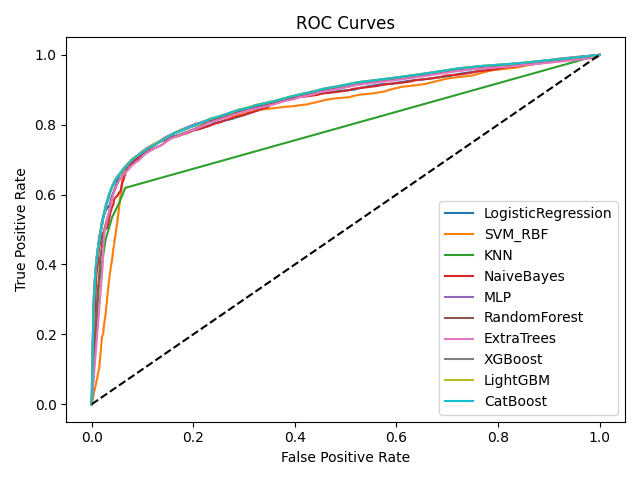

### Comparativo de Accuracy


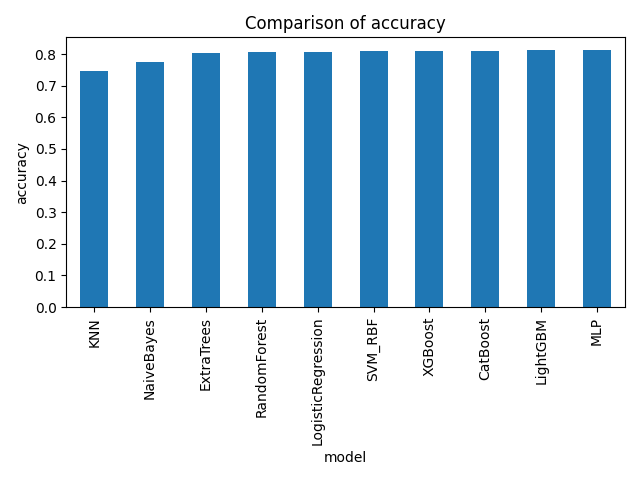

### Comparativo de Precision


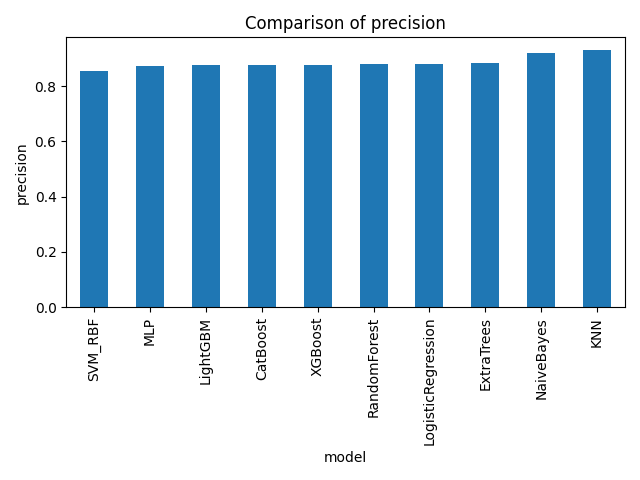

### Comparativo de Recall


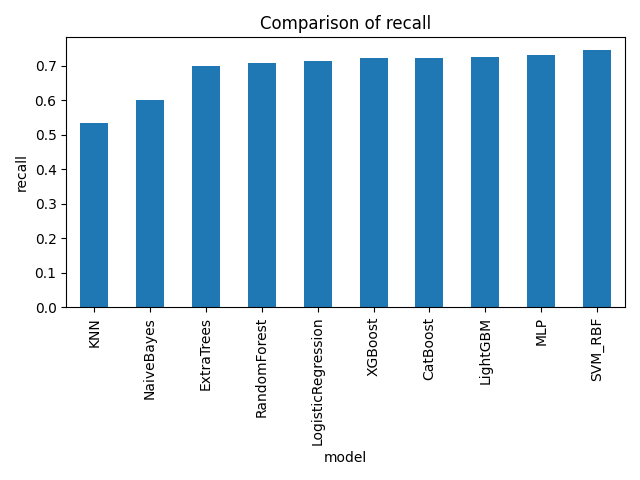

### Comparativo de F1


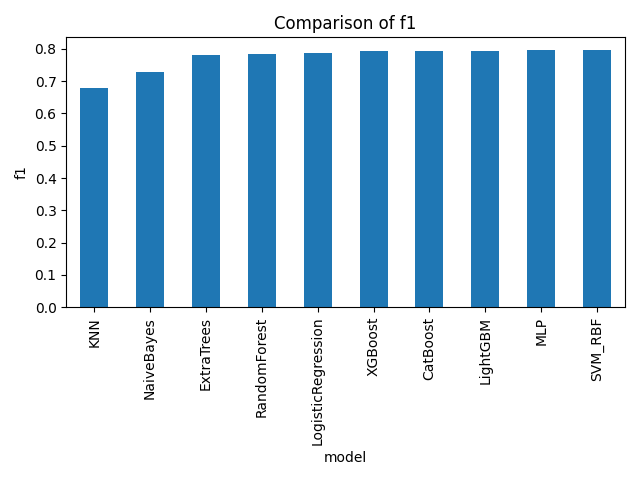

### Comparativo de Roc_auc


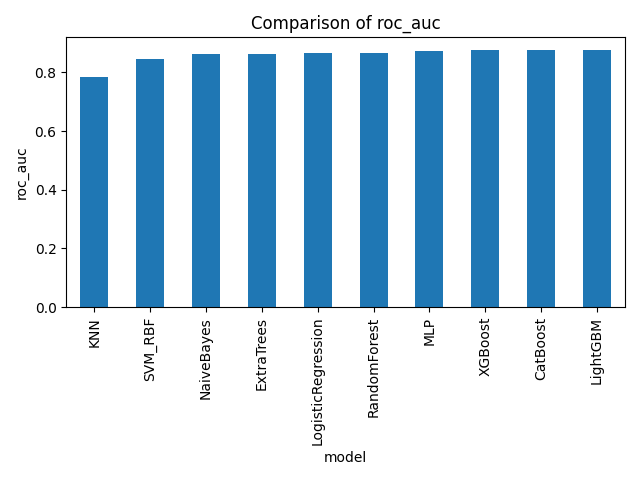

### Comparativo de Mutual_info


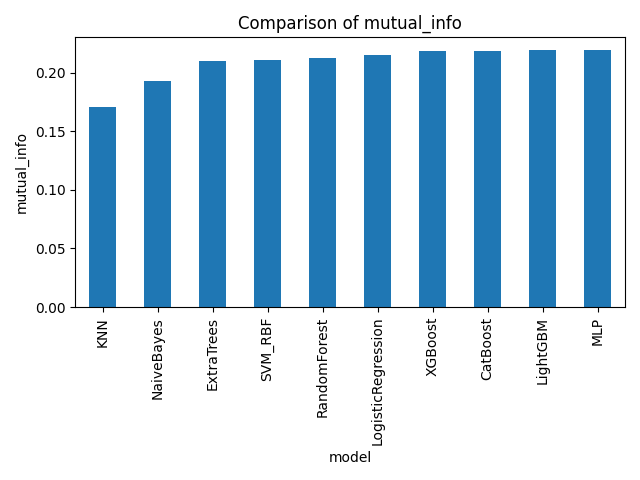

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Diretório de saída
orig_dir = "output/modelos_originais"
os.makedirs(orig_dir, exist_ok=True)

# 1) Salva a métrica e os gráficos como antes
save_metrics(metrics_orig, orig_dir, "metrics_original.csv")
plot_roc_curves(roc_curves_orig, os.path.join(orig_dir, "roc_curves_original.png"))
for m in ["accuracy","precision","recall","f1","roc_auc","mutual_info"]:
    plot_metrics_bar(metrics_orig, m, os.path.join(orig_dir, f"{m}_original.png"))

# 2) Carrega e exibe a tabela de métricas
metrics_df = pd.read_csv(os.path.join(orig_dir, "metrics_original.csv"))
print("### Métricas dos Modelos Originais")
display(metrics_df)

# 3) Exibe o gráfico ROC salvo
print("### Curvas ROC dos Modelos Originais")
display(Image(filename=os.path.join(orig_dir, "roc_curves_original.png")))

# 4) Exibe cada gráfico de métrica
for m in ["accuracy","precision","recall","f1","roc_auc","mutual_info"]:
    img_path = os.path.join(orig_dir, f"{m}_original.png")
    print(f"### Comparativo de {m.capitalize()}")
    display(Image(filename=img_path))

9. Otimização com Optuna

In [10]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# 0) Reuse o mesmo dicionário de modelos originais/paralelizados
models_optuna = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM_RBF":            SVC(kernel="rbf"),  
    "KNN":                KNeighborsClassifier(n_jobs=-1),
    "NaiveBayes":         GaussianNB(),
    "MLP":                MLPClassifier(max_iter=1000),
    "RandomForest":       RandomForestClassifier(n_jobs=-1),
    "ExtraTrees":         ExtraTreesClassifier(n_jobs=-1),
    "XGBoost":            xgb.XGBClassifier(eval_metric="logloss", n_jobs=-1),
    "LightGBM":           lgb.LGBMClassifier(n_jobs=-1),
    "CatBoost":           CatBoostClassifier(thread_count=-1, verbose=0)
}

# 1) Função de Optuna rápida usando exatamente esses 10 modelos
def run_optuna_fast(models: dict, X, y, n_trials_dict: dict, cv: int = 10):
    sampler = optuna.samplers.TPESampler(n_startup_trials=5)
    pruner  = optuna.pruners.MedianPruner(n_startup_trials=5, interval_steps=1)
    best_params = {}

    for name, _ in models.items():
        def objective(trial):
            # recria o modelo a cada trial
            if name == "LogisticRegression":
                model = LogisticRegression(
                    C=trial.suggest_loguniform("C", 1e-5, 1e2),
                    max_iter=1000
                )
            elif name == "SVM_RBF":
                model = SVC(
                    C=trial.suggest_loguniform("C", 1e-3, 1e2),
                    kernel="rbf"
                )
            elif name == "KNN":
                model = KNeighborsClassifier(
                    n_neighbors=trial.suggest_int("n_neighbors", 3, 15),
                    n_jobs=-1
                )
            elif name == "NaiveBayes":
                model = GaussianNB()
            elif name == "MLP":
                model = MLPClassifier(
                    hidden_layer_sizes=(
                        trial.suggest_int("h1", 50, 200),
                        trial.suggest_int("h2", 50, 200)
                    ),
                    learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),
                    max_iter=500
                )
            elif name == "RandomForest":
                model = RandomForestClassifier(
                    n_estimators=trial.suggest_int("n_estimators", 50, 200),
                    max_depth=trial.suggest_int("max_depth", 3, 20),
                    n_jobs=-1
                )
            elif name == "ExtraTrees":
                model = ExtraTreesClassifier(
                    n_estimators=trial.suggest_int("n_estimators", 50, 200),
                    max_depth=trial.suggest_int("max_depth", 3, 20),
                    n_jobs=-1
                )
            elif name == "XGBoost":
                model = xgb.XGBClassifier(
                    n_estimators=trial.suggest_int("n_estimators", 50, 200),
                    max_depth=trial.suggest_int("max_depth", 3, 20),
                    learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),
                    eval_metric="logloss",
                    n_jobs=-1
                )
            elif name == "LightGBM":
                model = lgb.LGBMClassifier(
                    num_leaves=trial.suggest_int("num_leaves", 20, 100),
                    learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),
                    n_jobs=-1
                )
            elif name == "CatBoost":
                model = CatBoostClassifier(
                    iterations=trial.suggest_int("iterations", 100, 500),
                    depth=trial.suggest_int("depth", 3, 10),
                    learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),
                    thread_count=-1,
                    verbose=0
                )
            else:
                # não deve acontecer, mas garante compatibilidade
                model = models[name]

            cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
            y_pred = cross_val_predict(model, X, y, cv=cv_split, n_jobs=-1)
            return f1_score(y, y_pred)

        study = optuna.create_study(
            direction="maximize",
            sampler=sampler,
            pruner=pruner
        )
        study.optimize(
            objective,
            n_trials=n_trials_dict.get(name, 30),
            show_progress_bar=True
        )
        best_params[name] = study.best_params

    return best_params

# 2) Executa o Optuna rápido com os mesmos modelos
n_trials_dict = {
    "LogisticRegression": 30,
    "SVM_RBF":            50,
    "KNN":                30,
    "NaiveBayes":         20,
    "MLP":                80,
    "RandomForest":       50,
    "ExtraTrees":         40,
    "XGBoost":            60,
    "LightGBM":           75,
    "CatBoost":           60
}

best_params = run_optuna_fast(models_optuna, X, y, n_trials_dict, cv=10)

# 3) Instancia os modelos otimizados
models_opt = {}
for name, params in best_params.items():
    if name == "XGBoost":
        models_opt[name] = xgb.XGBClassifier(**params, eval_metric="logloss", n_jobs=-1)
    elif name == "LightGBM":
        models_opt[name] = lgb.LGBMClassifier(**params, n_jobs=-1)
    elif name == "CatBoost":
        models_opt[name] = CatBoostClassifier(**params, thread_count=-1, verbose=0)
    else:
        cls = globals()[name]
        models_opt[name] = cls(**params)



[I 2025-07-31 16:09:53,875] A new study created in memory with name: no-name-88e949dd-f351-46f4-b484-72c4f40cc0b7


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:09:59,685] Trial 0 finished with value: 0.778418059755425 and parameters: {'C': 3.106741787073931e-05}. Best is trial 0 with value: 0.778418059755425.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:00,141] Trial 1 finished with value: 0.7878821322149873 and parameters: {'C': 0.30136245718126065}. Best is trial 1 with value: 0.7878821322149873.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:00,477] Trial 2 finished with value: 0.787971363895688 and parameters: {'C': 4.900433018211769e-05}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:00,784] Trial 3 finished with value: 0.7878821322149873 and parameters: {'C': 29.344481500266546}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:01,096] Trial 4 finished with value: 0.7878821322149873 and parameters: {'C': 3.8099155638880244}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:01,420] Trial 5 finished with value: 0.7878419900277823 and parameters: {'C': 5.4622879468599854e-05}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:01,742] Trial 6 finished with value: 0.7878966246666054 and parameters: {'C': 0.004181403797279424}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:01,964] Trial 7 finished with value: 0.7878743285998087 and parameters: {'C': 0.0026219710555626485}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:02,281] Trial 8 finished with value: 0.7879323031640912 and parameters: {'C': 0.0008485105739817933}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:02,600] Trial 9 finished with value: 0.7878821322149873 and parameters: {'C': 0.07214308060941739}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:02,913] Trial 10 finished with value: 0.7771892386251048 and parameters: {'C': 1.2597834941508884e-05}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:03,198] Trial 11 finished with value: 0.7878720977296979 and parameters: {'C': 0.00042191573211675023}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:03,680] Trial 12 finished with value: 0.7878720977296979 and parameters: {'C': 0.0003364967764744345}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:04,015] Trial 13 finished with value: 0.7878966246666054 and parameters: {'C': 0.004048428780827206}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:04,312] Trial 14 finished with value: 0.7878720977296979 and parameters: {'C': 0.00030702654468959064}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:04,612] Trial 15 finished with value: 0.7878821322149873 and parameters: {'C': 0.02572160709923068}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:04,886] Trial 16 finished with value: 0.7878419900277823 and parameters: {'C': 0.00015648117572818464}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:05,191] Trial 17 finished with value: 0.7879323031640912 and parameters: {'C': 0.0010830289404556008}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:05,517] Trial 18 finished with value: 0.7878821322149873 and parameters: {'C': 0.021724790398181138}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:05,809] Trial 19 finished with value: 0.7878419900277823 and parameters: {'C': 6.685221251947929e-05}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:06,117] Trial 20 finished with value: 0.7878821322149873 and parameters: {'C': 0.22415691052419734}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:06,441] Trial 21 finished with value: 0.7879178087231655 and parameters: {'C': 0.0014352434575545308}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:06,752] Trial 22 finished with value: 0.7879178087231655 and parameters: {'C': 0.0014984597110252146}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:07,053] Trial 23 finished with value: 0.7771892386251048 and parameters: {'C': 1.146013129172291e-05}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:07,366] Trial 24 finished with value: 0.7878821322149873 and parameters: {'C': 0.009630326086055267}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:07,688] Trial 25 finished with value: 0.7879323031640912 and parameters: {'C': 0.0010083901749039256}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:07,976] Trial 26 finished with value: 0.7878419900277823 and parameters: {'C': 9.870718970219708e-05}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:08,284] Trial 27 finished with value: 0.7879022021082841 and parameters: {'C': 0.000555108942311938}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),


[I 2025-07-31 16:10:08,598] Trial 28 finished with value: 0.7878821322149873 and parameters: {'C': 0.009557193897980844}. Best is trial 2 with value: 0.787971363895688.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-5, 1e2),
[I 2025-07-31 16:10:08,886] A new study created in memory with name: no-name-6ae71d55-b5b2-4091-af53-7b095a6a1a00


[I 2025-07-31 16:10:08,883] Trial 29 finished with value: 0.7778475831477145 and parameters: {'C': 2.4642196954408995e-05}. Best is trial 2 with value: 0.787971363895688.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 16:14:36,426] Trial 0 finished with value: 0.7888689670313587 and parameters: {'C': 0.15335276931395325}. Best is trial 0 with value: 0.7888689670313587.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 16:19:03,757] Trial 1 finished with value: 0.7960712442839095 and parameters: {'C': 1.7664656985502762}. Best is trial 1 with value: 0.7960712442839095.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 16:24:08,355] Trial 2 finished with value: 0.7961928482476428 and parameters: {'C': 6.711731583352795}. Best is trial 2 with value: 0.7961928482476428.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 16:28:36,237] Trial 3 finished with value: 0.7790827423167849 and parameters: {'C': 0.03986933130121311}. Best is trial 2 with value: 0.7961928482476428.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 16:33:02,997] Trial 4 finished with value: 0.7960639869036815 and parameters: {'C': 1.0452965817442872}. Best is trial 2 with value: 0.7961928482476428.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 16:41:05,094] Trial 5 finished with value: 0.7965866666666667 and parameters: {'C': 51.98431253188882}. Best is trial 5 with value: 0.7965866666666667.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 16:50:25,009] Trial 6 finished with value: 0.79667223664095 and parameters: {'C': 77.78789511116183}. Best is trial 6 with value: 0.79667223664095.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 16:54:55,459] Trial 7 finished with value: 0.7785600726777198 and parameters: {'C': 0.0019055009067710479}. Best is trial 6 with value: 0.79667223664095.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:03:05,244] Trial 8 finished with value: 0.7965866666666667 and parameters: {'C': 57.988356899811386}. Best is trial 6 with value: 0.79667223664095.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:07:28,508] Trial 9 finished with value: 0.7785621013985352 and parameters: {'C': 0.011334376415578867}. Best is trial 6 with value: 0.79667223664095.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:13:08,241] Trial 10 finished with value: 0.7963430685496781 and parameters: {'C': 12.45575066117248}. Best is trial 6 with value: 0.79667223664095.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:22:16,488] Trial 11 finished with value: 0.7967150170648464 and parameters: {'C': 75.33112519299767}. Best is trial 11 with value: 0.7967150170648464.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:32:11,404] Trial 12 finished with value: 0.7967650195520797 and parameters: {'C': 93.90010677242479}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:37:12,793] Trial 13 finished with value: 0.7962142641120066 and parameters: {'C': 7.225563454436216}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:43:33,404] Trial 14 finished with value: 0.7963430685496781 and parameters: {'C': 16.768890078107347}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:47:53,785] Trial 15 finished with value: 0.7960498220640569 and parameters: {'C': 1.097993243229915}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 17:57:46,289] Trial 16 finished with value: 0.7967650195520797 and parameters: {'C': 98.09613877150957}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:02:09,370] Trial 17 finished with value: 0.7888298846365135 and parameters: {'C': 0.17385800093230713}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:06:40,836] Trial 18 finished with value: 0.796099921713757 and parameters: {'C': 3.234039958380292}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:13:00,672] Trial 19 finished with value: 0.7963223133147196 and parameters: {'C': 22.138564259087694}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:17:51,056] Trial 20 finished with value: 0.7786461783017619 and parameters: {'C': 0.0011069204620390695}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:27:29,966] Trial 21 finished with value: 0.7967650195520797 and parameters: {'C': 94.01154050472269}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:34:11,263] Trial 22 finished with value: 0.796350962051428 and parameters: {'C': 25.305921759744784}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:44:17,336] Trial 23 finished with value: 0.7967222439475274 and parameters: {'C': 91.14958621126593}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:51:17,755] Trial 24 finished with value: 0.796401009993243 and parameters: {'C': 29.894212938491037}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 18:56:04,711] Trial 25 finished with value: 0.7961285960823385 and parameters: {'C': 4.590694664844606}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:01:27,672] Trial 26 finished with value: 0.7962930022412751 and parameters: {'C': 11.158733734643123}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:05:42,905] Trial 27 finished with value: 0.7898147470161822 and parameters: {'C': 0.5776711218478996}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:12:48,135] Trial 28 finished with value: 0.7964866114291811 and parameters: {'C': 35.0451674589514}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:17:06,402] Trial 29 finished with value: 0.7788350579822554 and parameters: {'C': 0.030015897289858606}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:21:39,949] Trial 30 finished with value: 0.7960926657414327 and parameters: {'C': 2.1764691197627144}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:31:32,854] Trial 31 finished with value: 0.7967650195520797 and parameters: {'C': 93.12778361842591}. Best is trial 12 with value: 0.7967650195520797.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:41:52,003] Trial 32 finished with value: 0.796786406213896 and parameters: {'C': 96.04628962987056}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:49:32,922] Trial 33 finished with value: 0.7964652122117316 and parameters: {'C': 34.55297314015486}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 19:54:37,232] Trial 34 finished with value: 0.7962142641120066 and parameters: {'C': 7.950641558130873}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 20:02:10,249] Trial 35 finished with value: 0.796501084521566 and parameters: {'C': 43.117533242118945}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 20:07:57,604] Trial 36 finished with value: 0.7963430685496781 and parameters: {'C': 14.02598965654081}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 20:15:54,018] Trial 37 finished with value: 0.7965438771156308 and parameters: {'C': 45.31551121212688}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 20:25:57,541] Trial 38 finished with value: 0.7967650195520797 and parameters: {'C': 91.43054444214496}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 20:32:16,519] Trial 39 finished with value: 0.7963005780346821 and parameters: {'C': 19.931986135184587}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 20:37:07,304] Trial 40 finished with value: 0.7961285960823385 and parameters: {'C': 4.615087423195206}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 20:45:40,408] Trial 41 finished with value: 0.7965866666666667 and parameters: {'C': 59.232507756741406}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 20:54:03,700] Trial 42 finished with value: 0.7965652722715071 and parameters: {'C': 57.74739112368931}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 21:03:20,038] Trial 43 finished with value: 0.7967650195520797 and parameters: {'C': 96.25868467341287}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 21:07:49,086] Trial 44 finished with value: 0.7785138357875611 and parameters: {'C': 0.004511040449600721}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 21:12:27,174] Trial 45 finished with value: 0.7829049589097512 and parameters: {'C': 0.06632249004788625}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 21:20:02,851] Trial 46 finished with value: 0.7965224811989973 and parameters: {'C': 45.47187960287182}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 21:30:19,549] Trial 47 finished with value: 0.7967436321299703 and parameters: {'C': 94.38067132828516}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-07-31 21:36:39,622] Trial 48 finished with value: 0.7963005780346821 and parameters: {'C': 19.588391310585816}. Best is trial 32 with value: 0.796786406213896.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e2),
[I 2025-07-31 21:41:58,618] A new study created in memory with name: no-name-fb298c0f-7fe2-4c4c-a490-7a4d90c9c414


[I 2025-07-31 21:41:58,590] Trial 49 finished with value: 0.7962142641120066 and parameters: {'C': 8.180929159104826}. Best is trial 32 with value: 0.796786406213896.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-31 21:42:01,853] Trial 0 finished with value: 0.7011183000186039 and parameters: {'n_neighbors': 7}. Best is trial 0 with value: 0.7011183000186039.
[I 2025-07-31 21:42:04,258] Trial 1 finished with value: 0.6422488342053988 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 0.7011183000186039.
[I 2025-07-31 21:42:06,661] Trial 2 finished with value: 0.7365506801840381 and parameters: {'n_neighbors': 11}. Best is trial 2 with value: 0.7365506801840381.
[I 2025-07-31 21:42:09,011] Trial 3 finished with value: 0.7011183000186039 and parameters: {'n_neighbors': 7}. Best is trial 2 with value: 0.7365506801840381.
[I 2025-07-31 21:42:11,382] Trial 4 finished with value: 0.7239219173099463 and parameters: {'n_neighbors': 9}. Best is trial 2 with value: 0.7365506801840381.
[I 2025-07-31 21:42:13,895] Trial 5 finished with value: 0.747150381259335 and parameters: {'n_neighbors': 15}. Best is trial 5 with value: 0.747150381259335.
[I 2025-07-31 21:42:16,317] Trial 6 fini

[I 2025-07-31 21:43:12,129] A new study created in memory with name: no-name-19cdc29a-8a63-4250-ba44-dc1b650fc074


[I 2025-07-31 21:43:12,127] Trial 29 finished with value: 0.747150381259335 and parameters: {'n_neighbors': 15}. Best is trial 5 with value: 0.747150381259335.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-07-31 21:43:12,479] Trial 0 finished with value: 0.727302048056765 and parameters: {}. Best is trial 0 with value: 0.727302048056765.
[I 2025-07-31 21:43:12,718] Trial 1 finished with value: 0.727302048056765 and parameters: {}. Best is trial 0 with value: 0.727302048056765.
[I 2025-07-31 21:43:12,874] Trial 2 finished with value: 0.727302048056765 and parameters: {}. Best is trial 0 with value: 0.727302048056765.
[I 2025-07-31 21:43:13,165] Trial 3 finished with value: 0.727302048056765 and parameters: {}. Best is trial 0 with value: 0.727302048056765.
[I 2025-07-31 21:43:13,401] Trial 4 finished with value: 0.727302048056765 and parameters: {}. Best is trial 0 with value: 0.727302048056765.
[I 2025-07-31 21:43:13,684] Trial 5 finished with value: 0.727302048056765 and parameters: {}. Best is trial 0 with value: 0.727302048056765.
[I 2025-07-31 21:43:13,984] Trial 6 finished with value: 0.727302048056765 and parameters: {}. Best is trial 0 with value: 0.727302048056765.
[I 202

[I 2025-07-31 21:43:17,252] A new study created in memory with name: no-name-0bb1c41e-7ffe-49b8-9b95-26eabfd9a589


[I 2025-07-31 21:43:17,248] Trial 19 finished with value: 0.727302048056765 and parameters: {}. Best is trial 0 with value: 0.727302048056765.


  0%|          | 0/80 [00:00<?, ?it/s]

C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 21:45:28,270] Trial 0 finished with value: 0.7947409519312837 and parameters: {'h1': 75, 'h2': 189, 'lr': 0.0018696546538107212}. Best is trial 0 with value: 0.7947409519312837.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 21:46:34,811] Trial 1 finished with value: 0.7952095374413422 and parameters: {'h1': 135, 'h2': 52, 'lr': 0.009275106372732628}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 21:46:57,909] Trial 2 finished with value: 0.7945690246632723 and parameters: {'h1': 61, 'h2': 50, 'lr': 0.00014662244127427865}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 21:49:14,520] Trial 3 finished with value: 0.795115135458818 and parameters: {'h1': 137, 'h2': 92, 'lr': 0.0008057766739176617}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 21:52:30,123] Trial 4 finished with value: 0.794780588726362 and parameters: {'h1': 131, 'h2': 179, 'lr': 0.0035833835838647195}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 21:54:03,669] Trial 5 finished with value: 0.7935240387244982 and parameters: {'h1': 200, 'h2': 52, 'lr': 0.008885776540847967}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 21:57:37,557] Trial 6 finished with value: 0.7948359450184301 and parameters: {'h1': 169, 'h2': 121, 'lr': 0.0004440269745176435}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 21:58:55,662] Trial 7 finished with value: 0.7937388258474113 and parameters: {'h1': 99, 'h2': 98, 'lr': 0.009132310451575877}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:01:45,480] Trial 8 finished with value: 0.7943414776244402 and parameters: {'h1': 163, 'h2': 153, 'lr': 0.0033183307374838418}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:02:22,779] Trial 9 finished with value: 0.794246426632893 and parameters: {'h1': 99, 'h2': 74, 'lr': 0.00010071669352880474}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:06:23,487] Trial 10 finished with value: 0.7947748991679081 and parameters: {'h1': 156, 'h2': 137, 'lr': 0.00041209901364124414}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:09:12,382] Trial 11 finished with value: 0.795203052602889 and parameters: {'h1': 129, 'h2': 89, 'lr': 0.0007898319584935787}. Best is trial 1 with value: 0.7952095374413422.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:11:26,537] Trial 12 finished with value: 0.7957545293458215 and parameters: {'h1': 107, 'h2': 79, 'lr': 0.0010333230943253915}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:12:41,257] Trial 13 finished with value: 0.7938806024579702 and parameters: {'h1': 103, 'h2': 67, 'lr': 0.0018901725149927326}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:15:04,294] Trial 14 finished with value: 0.7941063701593909 and parameters: {'h1': 110, 'h2': 112, 'lr': 0.00029222816388331047}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:15:58,182] Trial 15 finished with value: 0.7947099379672918 and parameters: {'h1': 79, 'h2': 73, 'lr': 0.004025789476346662}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:17:19,990] Trial 16 finished with value: 0.7952186335853014 and parameters: {'h1': 150, 'h2': 65, 'lr': 0.005698163375783236}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:19:49,620] Trial 17 finished with value: 0.795369030390738 and parameters: {'h1': 184, 'h2': 106, 'lr': 0.0016259783139760074}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:24:21,593] Trial 18 finished with value: 0.7950913138699343 and parameters: {'h1': 195, 'h2': 141, 'lr': 0.00151132834189059}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:27:57,441] Trial 19 finished with value: 0.7935534505101389 and parameters: {'h1': 184, 'h2': 109, 'lr': 0.0011850520812215085}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:33:08,358] Trial 20 finished with value: 0.7944956463252804 and parameters: {'h1': 177, 'h2': 158, 'lr': 0.000703337290373386}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:34:46,763] Trial 21 finished with value: 0.7931671452347422 and parameters: {'h1': 148, 'h2': 83, 'lr': 0.0052630347401592704}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:36:11,694] Trial 22 finished with value: 0.7951776649746193 and parameters: {'h1': 116, 'h2': 101, 'lr': 0.0022660402013704923}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:38:22,395] Trial 23 finished with value: 0.7950885084155542 and parameters: {'h1': 183, 'h2': 66, 'lr': 0.0012273330877701583}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:40:15,022] Trial 24 finished with value: 0.7944333272694197 and parameters: {'h1': 145, 'h2': 84, 'lr': 0.006243765605755181}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:41:52,569] Trial 25 finished with value: 0.794888086118322 and parameters: {'h1': 118, 'h2': 123, 'lr': 0.0025392481767907617}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:43:28,127] Trial 26 finished with value: 0.7944821561811862 and parameters: {'h1': 85, 'h2': 64, 'lr': 0.0005479578169438988}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:46:40,932] Trial 27 finished with value: 0.7943190094683176 and parameters: {'h1': 156, 'h2': 108, 'lr': 0.0002659035023892779}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:48:35,109] Trial 28 finished with value: 0.7944926058133606 and parameters: {'h1': 174, 'h2': 80, 'lr': 0.0026648809931026467}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:49:41,189] Trial 29 finished with value: 0.7945414847161572 and parameters: {'h1': 90, 'h2': 97, 'lr': 0.005864436000980585}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:51:34,674] Trial 30 finished with value: 0.7946310187623735 and parameters: {'h1': 145, 'h2': 62, 'lr': 0.001643997436777221}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:52:26,013] Trial 31 finished with value: 0.7950447999419595 and parameters: {'h1': 123, 'h2': 54, 'lr': 0.009561647439822801}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:53:31,259] Trial 32 finished with value: 0.7954636182181092 and parameters: {'h1': 136, 'h2': 58, 'lr': 0.0048016626701935464}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:54:22,641] Trial 33 finished with value: 0.795079431514203 and parameters: {'h1': 70, 'h2': 77, 'lr': 0.0047696975142779135}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:56:16,477] Trial 34 finished with value: 0.7950558213716108 and parameters: {'h1': 160, 'h2': 58, 'lr': 0.0009808243808363806}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:58:12,491] Trial 35 finished with value: 0.7947612551159619 and parameters: {'h1': 140, 'h2': 89, 'lr': 0.007140162545969525}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:59:15,361] Trial 36 finished with value: 0.7952951410913968 and parameters: {'h1': 131, 'h2': 50, 'lr': 0.003129088441720097}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 22:59:58,645] Trial 37 finished with value: 0.7952423258934237 and parameters: {'h1': 56, 'h2': 50, 'lr': 0.0031606259644917697}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:03:13,856] Trial 38 finished with value: 0.7939282260860047 and parameters: {'h1': 109, 'h2': 182, 'lr': 0.002062906329033746}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:06:28,826] Trial 39 finished with value: 0.7943824925870004 and parameters: {'h1': 134, 'h2': 200, 'lr': 0.004122906049928718}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:08:42,704] Trial 40 finished with value: 0.7948052890283497 and parameters: {'h1': 124, 'h2': 71, 'lr': 0.0013364669984997307}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:09:29,486] Trial 41 finished with value: 0.7950657596371882 and parameters: {'h1': 63, 'h2': 50, 'lr': 0.0031771378416626753}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:10:12,688] Trial 42 finished with value: 0.7931084883253554 and parameters: {'h1': 61, 'h2': 57, 'lr': 0.0029136641419229303}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:11:30,846] Trial 43 finished with value: 0.7941519190153666 and parameters: {'h1': 55, 'h2': 58, 'lr': 0.0010159254914180568}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:12:35,413] Trial 44 finished with value: 0.7953501044410135 and parameters: {'h1': 90, 'h2': 50, 'lr': 0.0018484274065619828}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:14:03,481] Trial 45 finished with value: 0.7932942469769146 and parameters: {'h1': 89, 'h2': 71, 'lr': 0.0016245724170458348}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:16:05,739] Trial 46 finished with value: 0.7944243262424253 and parameters: {'h1': 103, 'h2': 116, 'lr': 0.001988665855631111}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:17:38,473] Trial 47 finished with value: 0.7939696660347091 and parameters: {'h1': 93, 'h2': 61, 'lr': 0.0009445790579383184}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:18:49,877] Trial 48 finished with value: 0.7935807422266801 and parameters: {'h1': 111, 'h2': 76, 'lr': 0.0040756925751471}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:21:25,786] Trial 49 finished with value: 0.7941759941759942 and parameters: {'h1': 76, 'h2': 135, 'lr': 0.000626918423674268}. Best is trial 12 with value: 0.7957545293458215.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:22:53,627] Trial 50 finished with value: 0.7958292744525021 and parameters: {'h1': 129, 'h2': 93, 'lr': 0.0025132423600737618}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:24:07,494] Trial 51 finished with value: 0.7943460589345334 and parameters: {'h1': 131, 'h2': 94, 'lr': 0.007465179218864242}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:26:07,727] Trial 52 finished with value: 0.794827021717778 and parameters: {'h1': 99, 'h2': 102, 'lr': 0.0017327250650040124}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:27:37,190] Trial 53 finished with value: 0.7940267015897268 and parameters: {'h1': 119, 'h2': 91, 'lr': 0.002391823910087807}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:29:53,256] Trial 54 finished with value: 0.7943531471720138 and parameters: {'h1': 137, 'h2': 85, 'lr': 0.001401124467400051}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:31:07,060] Trial 55 finished with value: 0.7947282312306854 and parameters: {'h1': 128, 'h2': 69, 'lr': 0.0037455273554610666}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:32:04,211] Trial 56 finished with value: 0.7944602969775176 and parameters: {'h1': 105, 'h2': 55, 'lr': 0.0047676078106164334}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:35:12,563] Trial 57 finished with value: 0.7940768837989642 and parameters: {'h1': 191, 'h2': 118, 'lr': 0.002225184647862987}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:38:22,465] Trial 58 finished with value: 0.7952681616953334 and parameters: {'h1': 167, 'h2': 106, 'lr': 0.001203044806547637}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:40:08,589] Trial 59 finished with value: 0.7938692296490462 and parameters: {'h1': 114, 'h2': 127, 'lr': 0.0028187961617546593}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:41:22,100] Trial 60 finished with value: 0.7938405466970387 and parameters: {'h1': 82, 'h2': 80, 'lr': 0.0018526146431979364}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:44:37,492] Trial 61 finished with value: 0.7942413046247929 and parameters: {'h1': 166, 'h2': 110, 'lr': 0.0010842003409678171}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:48:20,972] Trial 62 finished with value: 0.7946235582599219 and parameters: {'h1': 198, 'h2': 99, 'lr': 0.0007581664449763112}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:51:05,503] Trial 63 finished with value: 0.7951145926100943 and parameters: {'h1': 185, 'h2': 107, 'lr': 0.0012177386239216096}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:54:34,391] Trial 64 finished with value: 0.7939720442632499 and parameters: {'h1': 176, 'h2': 102, 'lr': 0.0008885541836828689}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-07-31 23:56:23,372] Trial 65 finished with value: 0.7947068019049697 and parameters: {'h1': 153, 'h2': 63, 'lr': 0.0014601507504005081}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:01:00,074] Trial 66 finished with value: 0.7949949076094864 and parameters: {'h1': 172, 'h2': 127, 'lr': 0.0005066132860672573}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:02:13,756] Trial 67 finished with value: 0.7956216304525404 and parameters: {'h1': 95, 'h2': 88, 'lr': 0.0034331351658017976}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:03:42,764] Trial 68 finished with value: 0.7943803093008059 and parameters: {'h1': 98, 'h2': 86, 'lr': 0.003587985266999161}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:05:36,063] Trial 69 finished with value: 0.794106398091318 and parameters: {'h1': 141, 'h2': 79, 'lr': 0.0026351225493170807}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:06:58,010] Trial 70 finished with value: 0.7940748818611414 and parameters: {'h1': 93, 'h2': 95, 'lr': 0.00463428699781316}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:08:44,005] Trial 71 finished with value: 0.7949616131549813 and parameters: {'h1': 120, 'h2': 89, 'lr': 0.00226011613535688}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:10:24,192] Trial 72 finished with value: 0.7945887957524956 and parameters: {'h1': 126, 'h2': 106, 'lr': 0.0031580006545921754}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:11:42,412] Trial 73 finished with value: 0.7937330147555037 and parameters: {'h1': 85, 'h2': 54, 'lr': 0.0011933049503858701}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:13:26,509] Trial 74 finished with value: 0.7938558085230589 and parameters: {'h1': 133, 'h2': 74, 'lr': 0.0018870708464091782}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:14:32,858] Trial 75 finished with value: 0.7957331981092779 and parameters: {'h1': 71, 'h2': 67, 'lr': 0.0015701714819126124}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:15:30,998] Trial 76 finished with value: 0.7939529879460948 and parameters: {'h1': 71, 'h2': 66, 'lr': 0.0016173467343605528}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:16:24,688] Trial 77 finished with value: 0.7945468370930948 and parameters: {'h1': 107, 'h2': 60, 'lr': 0.00015979127448043784}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),


[I 2025-08-01 00:17:59,322] Trial 78 finished with value: 0.7947439963751699 and parameters: {'h1': 67, 'h2': 166, 'lr': 0.007179071770091932}. Best is trial 50 with value: 0.7958292744525021.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init=trial.suggest_loguniform("lr", 1e-4, 1e-2),
[I 2025-08-01 00:19:02,155] A new study created in memory with name: no-name-c36ddc60-d970-47d9-a7d9-09ae4b19c511


[I 2025-08-01 00:19:02,129] Trial 79 finished with value: 0.7943355357760425 and parameters: {'h1': 113, 'h2': 69, 'lr': 0.005460245508095074}. Best is trial 50 with value: 0.7958292744525021.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-01 00:19:11,763] Trial 0 finished with value: 0.7939911033326041 and parameters: {'n_estimators': 188, 'max_depth': 5}. Best is trial 0 with value: 0.7939911033326041.
[I 2025-08-01 00:19:14,869] Trial 1 finished with value: 0.7939372987135865 and parameters: {'n_estimators': 51, 'max_depth': 7}. Best is trial 0 with value: 0.7939911033326041.
[I 2025-08-01 00:19:19,290] Trial 2 finished with value: 0.7907019276491459 and parameters: {'n_estimators': 61, 'max_depth': 13}. Best is trial 0 with value: 0.7939911033326041.
[I 2025-08-01 00:19:24,203] Trial 3 finished with value: 0.7940288737772283 and parameters: {'n_estimators': 79, 'max_depth': 9}. Best is trial 3 with value: 0.7940288737772283.
[I 2025-08-01 00:19:31,261] Trial 4 finished with value: 0.7942735369651932 and parameters: {'n_estimators': 148, 'max_depth': 5}. Best is trial 4 with value: 0.7942735369651932.
[I 2025-08-01 00:19:42,562] Trial 5 finished with value: 0.7853800523193692 and parameters: {'n_estimators'

[I 2025-08-01 00:24:09,394] A new study created in memory with name: no-name-e57f5952-e513-437f-b6cc-0c36f57356f6


[I 2025-08-01 00:24:09,390] Trial 49 finished with value: 0.793895909968314 and parameters: {'n_estimators': 122, 'max_depth': 6}. Best is trial 41 with value: 0.797369356558834.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-08-01 00:24:14,839] Trial 0 finished with value: 0.7879401052205585 and parameters: {'n_estimators': 179, 'max_depth': 5}. Best is trial 0 with value: 0.7879401052205585.
[I 2025-08-01 00:24:16,799] Trial 1 finished with value: 0.7898935684685178 and parameters: {'n_estimators': 53, 'max_depth': 7}. Best is trial 1 with value: 0.7898935684685178.
[I 2025-08-01 00:24:20,599] Trial 2 finished with value: 0.7954676466349618 and parameters: {'n_estimators': 100, 'max_depth': 9}. Best is trial 2 with value: 0.7954676466349618.
[I 2025-08-01 00:24:24,944] Trial 3 finished with value: 0.7951212481533528 and parameters: {'n_estimators': 115, 'max_depth': 9}. Best is trial 2 with value: 0.7954676466349618.
[I 2025-08-01 00:24:29,347] Trial 4 finished with value: 0.7903199313780958 and parameters: {'n_estimators': 87, 'max_depth': 16}. Best is trial 2 with value: 0.7954676466349618.
[I 2025-08-01 00:24:37,053] Trial 5 finished with value: 0.7924191669094087 and parameters: {'n_estimators

[I 2025-08-01 00:26:58,596] A new study created in memory with name: no-name-42542acf-142c-43e1-9b8a-128d95c05e03


[I 2025-08-01 00:26:58,590] Trial 39 finished with value: 0.7940984320557491 and parameters: {'n_estimators': 102, 'max_depth': 12}. Best is trial 36 with value: 0.7955355535553555.


  0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:00,416] Trial 0 finished with value: 0.7868344988344989 and parameters: {'n_estimators': 72, 'max_depth': 4, 'lr': 0.0051565025004515486}. Best is trial 0 with value: 0.7868344988344989.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:04,005] Trial 1 finished with value: 0.7925601750547046 and parameters: {'n_estimators': 108, 'max_depth': 12, 'lr': 0.02822221796032309}. Best is trial 1 with value: 0.7925601750547046.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:09,462] Trial 2 finished with value: 0.7909647919524463 and parameters: {'n_estimators': 170, 'max_depth': 14, 'lr': 0.06874721788612217}. Best is trial 1 with value: 0.7925601750547046.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:11,818] Trial 3 finished with value: 0.7947497058024803 and parameters: {'n_estimators': 79, 'max_depth': 9, 'lr': 0.006739732232367643}. Best is trial 3 with value: 0.7947497058024803.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:16,149] Trial 4 finished with value: 0.7909691347860293 and parameters: {'n_estimators': 132, 'max_depth': 14, 'lr': 0.010330955754425672}. Best is trial 3 with value: 0.7947497058024803.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:17,427] Trial 5 finished with value: 0.798001098686892 and parameters: {'n_estimators': 62, 'max_depth': 5, 'lr': 0.0010789501382668292}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:18,313] Trial 6 finished with value: 0.7784900284900285 and parameters: {'n_estimators': 51, 'max_depth': 3, 'lr': 0.0010855618002755846}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:23,840] Trial 7 finished with value: 0.7901379512767831 and parameters: {'n_estimators': 195, 'max_depth': 20, 'lr': 0.001038540161837146}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:26,244] Trial 8 finished with value: 0.7942670867403617 and parameters: {'n_estimators': 122, 'max_depth': 7, 'lr': 0.0029339294737438936}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:28,266] Trial 9 finished with value: 0.7941921262137691 and parameters: {'n_estimators': 98, 'max_depth': 7, 'lr': 0.002301971533183969}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:33,546] Trial 10 finished with value: 0.7906380484946158 and parameters: {'n_estimators': 149, 'max_depth': 19, 'lr': 0.015315998520768669}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:35,370] Trial 11 finished with value: 0.7937235222458591 and parameters: {'n_estimators': 80, 'max_depth': 8, 'lr': 0.0049113466438305605}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:36,706] Trial 12 finished with value: 0.7944195171574415 and parameters: {'n_estimators': 50, 'max_depth': 9, 'lr': 0.025458670245087755}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:38,153] Trial 13 finished with value: 0.7940945958261186 and parameters: {'n_estimators': 79, 'max_depth': 5, 'lr': 0.09962429327066576}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:39,925] Trial 14 finished with value: 0.7932727272727272 and parameters: {'n_estimators': 71, 'max_depth': 10, 'lr': 0.002492729451296953}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:41,874] Trial 15 finished with value: 0.794083400043665 and parameters: {'n_estimators': 100, 'max_depth': 6, 'lr': 0.004452022320891651}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:43,575] Trial 16 finished with value: 0.7926864801864801 and parameters: {'n_estimators': 61, 'max_depth': 11, 'lr': 0.0016706637183999894}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:46,389] Trial 17 finished with value: 0.7906559179186515 and parameters: {'n_estimators': 86, 'max_depth': 15, 'lr': 0.008279956801124722}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:48,130] Trial 18 finished with value: 0.7943029905656941 and parameters: {'n_estimators': 130, 'max_depth': 3, 'lr': 0.03902323566983274}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:50,297] Trial 19 finished with value: 0.7928409340458239 and parameters: {'n_estimators': 113, 'max_depth': 5, 'lr': 0.012198777956092867}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:52,454] Trial 20 finished with value: 0.7950371309545372 and parameters: {'n_estimators': 93, 'max_depth': 9, 'lr': 0.0017004771166209299}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:54,717] Trial 21 finished with value: 0.7950371309545372 and parameters: {'n_estimators': 91, 'max_depth': 9, 'lr': 0.0016891168248882342}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:57,202] Trial 22 finished with value: 0.7914313392188043 and parameters: {'n_estimators': 91, 'max_depth': 12, 'lr': 0.0016160494251131557}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:27:58,998] Trial 23 finished with value: 0.7933899355026783 and parameters: {'n_estimators': 60, 'max_depth': 8, 'lr': 0.001527899987460034}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:01,608] Trial 24 finished with value: 0.7930689648902707 and parameters: {'n_estimators': 96, 'max_depth': 10, 'lr': 0.0033252381406515953}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:03,691] Trial 25 finished with value: 0.7899526622876225 and parameters: {'n_estimators': 65, 'max_depth': 17, 'lr': 0.0010026351308072847}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:05,822] Trial 26 finished with value: 0.7939020175007732 and parameters: {'n_estimators': 109, 'max_depth': 6, 'lr': 0.0021587393875153143}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:08,913] Trial 27 finished with value: 0.7927022450428798 and parameters: {'n_estimators': 118, 'max_depth': 11, 'lr': 0.0015385622122759015}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:11,451] Trial 28 finished with value: 0.7907470443980821 and parameters: {'n_estimators': 89, 'max_depth': 13, 'lr': 0.0034259876942596685}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:12,832] Trial 29 finished with value: 0.7974600471806879 and parameters: {'n_estimators': 74, 'max_depth': 5, 'lr': 0.0018997458615916502}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:14,114] Trial 30 finished with value: 0.7859091758549803 and parameters: {'n_estimators': 71, 'max_depth': 4, 'lr': 0.003939433285693113}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:15,315] Trial 31 finished with value: 0.7974600471806879 and parameters: {'n_estimators': 62, 'max_depth': 5, 'lr': 0.0019788655412436317}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:16,520] Trial 32 finished with value: 0.798001098686892 and parameters: {'n_estimators': 58, 'max_depth': 5, 'lr': 0.00130971441247574}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:17,592] Trial 33 finished with value: 0.7845945641141311 and parameters: {'n_estimators': 58, 'max_depth': 4, 'lr': 0.0012338980273227237}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:18,925] Trial 34 finished with value: 0.7909087568441554 and parameters: {'n_estimators': 70, 'max_depth': 5, 'lr': 0.006234452690179702}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:20,071] Trial 35 finished with value: 0.7937172393709959 and parameters: {'n_estimators': 50, 'max_depth': 6, 'lr': 0.002237868603544754}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:21,224] Trial 36 finished with value: 0.7809093624010751 and parameters: {'n_estimators': 79, 'max_depth': 3, 'lr': 0.0012703845049157711}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:22,648] Trial 37 finished with value: 0.7937550156854162 and parameters: {'n_estimators': 59, 'max_depth': 7, 'lr': 0.002651060510358518}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:25,005] Trial 38 finished with value: 0.7859264933948691 and parameters: {'n_estimators': 165, 'max_depth': 4, 'lr': 0.001988448720418155}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:26,355] Trial 39 finished with value: 0.798001098686892 and parameters: {'n_estimators': 67, 'max_depth': 5, 'lr': 0.001281848615199006}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:29,249] Trial 40 finished with value: 0.7941996247244639 and parameters: {'n_estimators': 144, 'max_depth': 7, 'lr': 0.0012452790301498726}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:30,536] Trial 41 finished with value: 0.798001098686892 and parameters: {'n_estimators': 68, 'max_depth': 5, 'lr': 0.0013285016760027034}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:31,874] Trial 42 finished with value: 0.784555520048123 and parameters: {'n_estimators': 77, 'max_depth': 4, 'lr': 0.0011134115857911531}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:33,230] Trial 43 finished with value: 0.79367332823705 and parameters: {'n_estimators': 69, 'max_depth': 6, 'lr': 0.0013121372366750172}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:35,635] Trial 44 finished with value: 0.7868924970972557 and parameters: {'n_estimators': 198, 'max_depth': 3, 'lr': 0.0013968559461392453}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:37,054] Trial 45 finished with value: 0.7932850919563276 and parameters: {'n_estimators': 55, 'max_depth': 8, 'lr': 0.0010510032137237362}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:38,600] Trial 46 finished with value: 0.7935013884380973 and parameters: {'n_estimators': 83, 'max_depth': 5, 'lr': 0.002690930624476198}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:40,734] Trial 47 finished with value: 0.7941599985418224 and parameters: {'n_estimators': 103, 'max_depth': 7, 'lr': 0.003121011186786555}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:41,874] Trial 48 finished with value: 0.7847497417597896 and parameters: {'n_estimators': 65, 'max_depth': 4, 'lr': 0.0019152176621507473}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:43,103] Trial 49 finished with value: 0.7941626585045911 and parameters: {'n_estimators': 74, 'max_depth': 3, 'lr': 0.04727725423725415}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:44,281] Trial 50 finished with value: 0.79398282887078 and parameters: {'n_estimators': 52, 'max_depth': 6, 'lr': 0.001026210206985259}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:45,608] Trial 51 finished with value: 0.7974600471806879 and parameters: {'n_estimators': 65, 'max_depth': 5, 'lr': 0.0018394049687264602}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:46,869] Trial 52 finished with value: 0.7928630249794125 and parameters: {'n_estimators': 64, 'max_depth': 5, 'lr': 0.02164222744632487}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:48,144] Trial 53 finished with value: 0.7938281264215142 and parameters: {'n_estimators': 55, 'max_depth': 6, 'lr': 0.0013540634778451634}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:49,972] Trial 54 finished with value: 0.7935178441369264 and parameters: {'n_estimators': 77, 'max_depth': 8, 'lr': 0.0023191048618936795}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:51,603] Trial 55 finished with value: 0.7924811479610513 and parameters: {'n_estimators': 85, 'max_depth': 5, 'lr': 0.00603896478542536}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:54,424] Trial 56 finished with value: 0.7864220799820852 and parameters: {'n_estimators': 187, 'max_depth': 4, 'lr': 0.0019660857536077524}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:56,070] Trial 57 finished with value: 0.7939896184318368 and parameters: {'n_estimators': 73, 'max_depth': 7, 'lr': 0.001452089199945851}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:28:58,079] Trial 58 finished with value: 0.7901465544122233 and parameters: {'n_estimators': 66, 'max_depth': 16, 'lr': 0.004129268443994065}. Best is trial 5 with value: 0.798001098686892.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),
[I 2025-08-01 00:28:59,017] A new study created in memory with name: no-name-a874bc99-403a-4ee1-995f-44f67b35fad8


[I 2025-08-01 00:28:59,013] Trial 59 finished with value: 0.7809957453161156 and parameters: {'n_estimators': 57, 'max_depth': 3, 'lr': 0.001729019078566459}. Best is trial 5 with value: 0.798001098686892.


  0%|          | 0/75 [00:00<?, ?it/s]

C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:05,454] Trial 0 finished with value: 0.7931782154765592 and parameters: {'num_leaves': 90, 'lr': 0.006557512660763638}. Best is trial 0 with value: 0.7931782154765592.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:08,749] Trial 1 finished with value: 0.7938328236493374 and parameters: {'num_leaves': 31, 'lr': 0.0033202757481364835}. Best is trial 1 with value: 0.7938328236493374.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:13,730] Trial 2 finished with value: 0.7930789286560797 and parameters: {'num_leaves': 84, 'lr': 0.05941186203684232}. Best is trial 1 with value: 0.7938328236493374.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:18,941] Trial 3 finished with value: 0.7928955278258494 and parameters: {'num_leaves': 87, 'lr': 0.003358164798156798}. Best is trial 1 with value: 0.7938328236493374.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:23,897] Trial 4 finished with value: 0.7923667743053655 and parameters: {'num_leaves': 78, 'lr': 0.0015282885156706792}. Best is trial 1 with value: 0.7938328236493374.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:26,839] Trial 5 finished with value: 0.7933718211049401 and parameters: {'num_leaves': 25, 'lr': 0.023982231384205705}. Best is trial 1 with value: 0.7938328236493374.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:29,865] Trial 6 finished with value: 0.7931670103845382 and parameters: {'num_leaves': 28, 'lr': 0.012394026939316958}. Best is trial 1 with value: 0.7938328236493374.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:33,560] Trial 7 finished with value: 0.7932808054278836 and parameters: {'num_leaves': 48, 'lr': 0.0011071743938510282}. Best is trial 1 with value: 0.7938328236493374.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:37,532] Trial 8 finished with value: 0.7938956350508697 and parameters: {'num_leaves': 50, 'lr': 0.004010915749716867}. Best is trial 8 with value: 0.7938956350508697.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:41,355] Trial 9 finished with value: 0.7930299108688916 and parameters: {'num_leaves': 59, 'lr': 0.0888776107761534}. Best is trial 8 with value: 0.7938956350508697.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:45,202] Trial 10 finished with value: 0.7938817180777364 and parameters: {'num_leaves': 46, 'lr': 0.02002228522791708}. Best is trial 8 with value: 0.7938956350508697.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:48,878] Trial 11 finished with value: 0.7936802973977695 and parameters: {'num_leaves': 46, 'lr': 0.02256361476018983}. Best is trial 8 with value: 0.7938956350508697.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:53,318] Trial 12 finished with value: 0.7938467139996359 and parameters: {'num_leaves': 65, 'lr': 0.008090136186646177}. Best is trial 8 with value: 0.7938956350508697.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:29:57,000] Trial 13 finished with value: 0.7936560021875855 and parameters: {'num_leaves': 42, 'lr': 0.02450959135525263}. Best is trial 8 with value: 0.7938956350508697.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:01,346] Trial 14 finished with value: 0.7940394214303931 and parameters: {'num_leaves': 59, 'lr': 0.004055330892866368}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:05,865] Trial 15 finished with value: 0.7933920463869591 and parameters: {'num_leaves': 71, 'lr': 0.0034518106475536687}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:10,470] Trial 16 finished with value: 0.7932632654550763 and parameters: {'num_leaves': 58, 'lr': 0.0019183690593096636}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:16,715] Trial 17 finished with value: 0.7931869933509427 and parameters: {'num_leaves': 98, 'lr': 0.00491003760477867}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:20,845] Trial 18 finished with value: 0.7939326539169751 and parameters: {'num_leaves': 55, 'lr': 0.012072868555956786}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:25,340] Trial 19 finished with value: 0.7935541498805987 and parameters: {'num_leaves': 69, 'lr': 0.015204060863559025}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:28,593] Trial 20 finished with value: 0.793996972957202 and parameters: {'num_leaves': 36, 'lr': 0.03953758835249469}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:31,960] Trial 21 finished with value: 0.7939332069418112 and parameters: {'num_leaves': 39, 'lr': 0.04861102569372598}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:35,126] Trial 22 finished with value: 0.793984140005469 and parameters: {'num_leaves': 36, 'lr': 0.0518543888406385}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:38,443] Trial 23 finished with value: 0.7939101103108761 and parameters: {'num_leaves': 35, 'lr': 0.03776124496194151}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:41,455] Trial 24 finished with value: 0.7931015603613468 and parameters: {'num_leaves': 34, 'lr': 0.08427157450141387}. Best is trial 14 with value: 0.7940394214303931.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:45,528] Trial 25 finished with value: 0.7943644538289313 and parameters: {'num_leaves': 53, 'lr': 0.04591717237003066}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:50,116] Trial 26 finished with value: 0.7936120175742439 and parameters: {'num_leaves': 66, 'lr': 0.033984266120431386}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:54,199] Trial 27 finished with value: 0.7931733138632837 and parameters: {'num_leaves': 53, 'lr': 0.002046912359806837}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:30:56,987] Trial 28 finished with value: 0.7938298649142023 and parameters: {'num_leaves': 20, 'lr': 0.033593996654254416}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:01,932] Trial 29 finished with value: 0.793424238562508 and parameters: {'num_leaves': 78, 'lr': 0.007235837529962155}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:05,300] Trial 30 finished with value: 0.7933549728290601 and parameters: {'num_leaves': 42, 'lr': 0.07489789807837945}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:09,389] Trial 31 finished with value: 0.7936797215286764 and parameters: {'num_leaves': 63, 'lr': 0.053599574805733394}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:11,919] Trial 32 finished with value: 0.7936108068638189 and parameters: {'num_leaves': 21, 'lr': 0.04515037006631341}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:15,175] Trial 33 finished with value: 0.7940484656200427 and parameters: {'num_leaves': 37, 'lr': 0.061932760541001664}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:17,891] Trial 34 finished with value: 0.793842449887829 and parameters: {'num_leaves': 29, 'lr': 0.06374825031450154}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:21,380] Trial 35 finished with value: 0.7927980570823366 and parameters: {'num_leaves': 53, 'lr': 0.09979158933713583}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:24,942] Trial 36 finished with value: 0.7940185417918875 and parameters: {'num_leaves': 41, 'lr': 0.005544855544103158}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:28,467] Trial 37 finished with value: 0.7940055787497038 and parameters: {'num_leaves': 41, 'lr': 0.00226853711442811}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:32,391] Trial 38 finished with value: 0.7943363218893505 and parameters: {'num_leaves': 50, 'lr': 0.0054749084249080225}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:37,291] Trial 39 finished with value: 0.7931908068602256 and parameters: {'num_leaves': 75, 'lr': 0.00905860554332454}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:41,251] Trial 40 finished with value: 0.7934556597234889 and parameters: {'num_leaves': 50, 'lr': 0.002721872048524849}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:45,547] Trial 41 finished with value: 0.7939682019341091 and parameters: {'num_leaves': 57, 'lr': 0.005306610658538943}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:49,466] Trial 42 finished with value: 0.7941069214499307 and parameters: {'num_leaves': 51, 'lr': 0.006443456417797775}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:53,287] Trial 43 finished with value: 0.7939846882974845 and parameters: {'num_leaves': 47, 'lr': 0.004157787214339208}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:31:57,572] Trial 44 finished with value: 0.793764682315663 and parameters: {'num_leaves': 62, 'lr': 0.00674667887167316}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:01,339] Trial 45 finished with value: 0.7943094466100769 and parameters: {'num_leaves': 51, 'lr': 0.010268572699654501}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:05,266] Trial 46 finished with value: 0.7941755357923895 and parameters: {'num_leaves': 53, 'lr': 0.015984562090273508}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:09,075] Trial 47 finished with value: 0.794279468026963 and parameters: {'num_leaves': 51, 'lr': 0.011008684523885917}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:12,859] Trial 48 finished with value: 0.7939048174543863 and parameters: {'num_leaves': 45, 'lr': 0.01742098911519585}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:17,024] Trial 49 finished with value: 0.79402974194489 and parameters: {'num_leaves': 55, 'lr': 0.010874990799858248}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:20,899] Trial 50 finished with value: 0.7943058163060714 and parameters: {'num_leaves': 49, 'lr': 0.015724358741260235}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:24,726] Trial 51 finished with value: 0.7942887361184559 and parameters: {'num_leaves': 49, 'lr': 0.014455616839873266}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:28,660] Trial 52 finished with value: 0.79402974194489 and parameters: {'num_leaves': 45, 'lr': 0.009233756618952304}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:33,398] Trial 53 finished with value: 0.794245286459283 and parameters: {'num_leaves': 49, 'lr': 0.014055735469604239}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:38,089] Trial 54 finished with value: 0.7938889597028242 and parameters: {'num_leaves': 61, 'lr': 0.02164131246424195}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:42,459] Trial 55 finished with value: 0.7937798519706858 and parameters: {'num_leaves': 56, 'lr': 0.026696818331936472}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:46,218] Trial 56 finished with value: 0.7939674666277627 and parameters: {'num_leaves': 44, 'lr': 0.012517020651258317}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:50,217] Trial 57 finished with value: 0.7941894798235701 and parameters: {'num_leaves': 48, 'lr': 0.010122245465315101}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:54,331] Trial 58 finished with value: 0.7940189642596645 and parameters: {'num_leaves': 52, 'lr': 0.008261346791447667}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:32:59,200] Trial 59 finished with value: 0.7939575939575939 and parameters: {'num_leaves': 65, 'lr': 0.018737542567152213}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:03,684] Trial 60 finished with value: 0.7936259047896876 and parameters: {'num_leaves': 60, 'lr': 0.01191774907922663}. Best is trial 25 with value: 0.7943644538289313.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:07,650] Trial 61 finished with value: 0.7944741110645356 and parameters: {'num_leaves': 49, 'lr': 0.013674425707280943}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:11,567] Trial 62 finished with value: 0.7942597691508179 and parameters: {'num_leaves': 48, 'lr': 0.014880182064567427}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:15,675] Trial 63 finished with value: 0.7939145486016216 and parameters: {'num_leaves': 55, 'lr': 0.025309487959048017}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:19,651] Trial 64 finished with value: 0.7940024412906047 and parameters: {'num_leaves': 43, 'lr': 0.00812845244551418}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:23,256] Trial 65 finished with value: 0.79374863228536 and parameters: {'num_leaves': 39, 'lr': 0.030170420295834433}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:27,903] Trial 66 finished with value: 0.7928451363005189 and parameters: {'num_leaves': 58, 'lr': 0.0010861104720950154}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:31,879] Trial 67 finished with value: 0.7943233986737593 and parameters: {'num_leaves': 50, 'lr': 0.012387929221587874}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:35,917] Trial 68 finished with value: 0.7939540904698525 and parameters: {'num_leaves': 47, 'lr': 0.017553413435649232}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:39,453] Trial 69 finished with value: 0.7934927322135289 and parameters: {'num_leaves': 33, 'lr': 0.0014403697918598404}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:43,467] Trial 70 finished with value: 0.7940248417750378 and parameters: {'num_leaves': 55, 'lr': 0.012803707492047532}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:47,484] Trial 71 finished with value: 0.7944037599737677 and parameters: {'num_leaves': 51, 'lr': 0.010787907357695402}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:51,370] Trial 72 finished with value: 0.7940619307832423 and parameters: {'num_leaves': 50, 'lr': 0.02058306522183278}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:33:54,975] Trial 73 finished with value: 0.7940313735492922 and parameters: {'num_leaves': 39, 'lr': 0.009748952402998435}. Best is trial 61 with value: 0.7944741110645356.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:86: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),
[I 2025-08-01 00:33:59,109] A new study created in memory with name: no-name-0cce63a2-ecb7-4ffb-b6db-929ff4c61a66


[I 2025-08-01 00:33:59,105] Trial 74 finished with value: 0.7941364158477219 and parameters: {'num_leaves': 53, 'lr': 0.013698379858553399}. Best is trial 61 with value: 0.7944741110645356.


  0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:34:09,733] Trial 0 finished with value: 0.7958282030853915 and parameters: {'iterations': 160, 'depth': 4, 'lr': 0.008917806836026883}. Best is trial 0 with value: 0.7958282030853915.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:34:55,913] Trial 1 finished with value: 0.7949965505972914 and parameters: {'iterations': 328, 'depth': 9, 'lr': 0.015154085230098212}. Best is trial 0 with value: 0.7958282030853915.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:35:06,543] Trial 2 finished with value: 0.7951029291738461 and parameters: {'iterations': 156, 'depth': 10, 'lr': 0.00596786112908459}. Best is trial 0 with value: 0.7958282030853915.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:35:13,197] Trial 3 finished with value: 0.7952938617163989 and parameters: {'iterations': 144, 'depth': 4, 'lr': 0.07724385770699742}. Best is trial 0 with value: 0.7958282030853915.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:35:46,306] Trial 4 finished with value: 0.7966077332183412 and parameters: {'iterations': 339, 'depth': 3, 'lr': 0.0012633616560075859}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:36:32,024] Trial 5 finished with value: 0.7962402765773552 and parameters: {'iterations': 479, 'depth': 3, 'lr': 0.0010389788016761242}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:37:17,328] Trial 6 finished with value: 0.795291300877893 and parameters: {'iterations': 350, 'depth': 7, 'lr': 0.0010295947031043803}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:38:14,420] Trial 7 finished with value: 0.7954903844411013 and parameters: {'iterations': 445, 'depth': 6, 'lr': 0.0029070610775916725}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:38:47,083] Trial 8 finished with value: 0.794816336174776 and parameters: {'iterations': 256, 'depth': 6, 'lr': 0.03861932293181804}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:39:12,456] Trial 9 finished with value: 0.7964012595591543 and parameters: {'iterations': 259, 'depth': 3, 'lr': 0.004693264399774008}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:40:09,164] Trial 10 finished with value: 0.7954170519026124 and parameters: {'iterations': 400, 'depth': 8, 'lr': 0.0018693277080994047}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:40:33,538] Trial 11 finished with value: 0.7961982935522195 and parameters: {'iterations': 250, 'depth': 3, 'lr': 0.0038850620150675235}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:41:03,781] Trial 12 finished with value: 0.7956113193199718 and parameters: {'iterations': 258, 'depth': 5, 'lr': 0.019043467618838725}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:41:45,160] Trial 13 finished with value: 0.7958947672737785 and parameters: {'iterations': 369, 'depth': 4, 'lr': 0.0021883167590542444}. Best is trial 4 with value: 0.7966077332183412.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:42:12,551] Trial 14 finished with value: 0.7966531713900135 and parameters: {'iterations': 289, 'depth': 3, 'lr': 0.004988123486363734}. Best is trial 14 with value: 0.7966531713900135.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:42:47,777] Trial 15 finished with value: 0.7956140985742202 and parameters: {'iterations': 303, 'depth': 5, 'lr': 0.008891810308241831}. Best is trial 14 with value: 0.7966531713900135.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:43:12,885] Trial 16 finished with value: 0.7952781605860594 and parameters: {'iterations': 208, 'depth': 5, 'lr': 0.002051182697977847}. Best is trial 14 with value: 0.7966531713900135.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:43:51,082] Trial 17 finished with value: 0.7957335261683087 and parameters: {'iterations': 397, 'depth': 3, 'lr': 0.018901147294370337}. Best is trial 14 with value: 0.7966531713900135.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:44:31,959] Trial 18 finished with value: 0.7953263058584465 and parameters: {'iterations': 306, 'depth': 7, 'lr': 0.0014342775994822489}. Best is trial 14 with value: 0.7966531713900135.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:44:53,557] Trial 19 finished with value: 0.7958357432041643 and parameters: {'iterations': 206, 'depth': 4, 'lr': 0.0035985662279056675}. Best is trial 14 with value: 0.7966531713900135.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:45:40,745] Trial 20 finished with value: 0.7956919178206172 and parameters: {'iterations': 407, 'depth': 5, 'lr': 0.0061313629305317745}. Best is trial 14 with value: 0.7966531713900135.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:46:07,549] Trial 21 finished with value: 0.7966687052559629 and parameters: {'iterations': 277, 'depth': 3, 'lr': 0.0052789769706776506}. Best is trial 21 with value: 0.7966687052559629.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:46:41,229] Trial 22 finished with value: 0.7959916945021215 and parameters: {'iterations': 339, 'depth': 3, 'lr': 0.011239420994223731}. Best is trial 21 with value: 0.7966687052559629.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:47:03,884] Trial 23 finished with value: 0.795725799148782 and parameters: {'iterations': 216, 'depth': 4, 'lr': 0.03237145350660131}. Best is trial 21 with value: 0.7966687052559629.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:47:31,759] Trial 24 finished with value: 0.7968131789079922 and parameters: {'iterations': 288, 'depth': 3, 'lr': 0.005988458007527152}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:48:02,256] Trial 25 finished with value: 0.7962574958456758 and parameters: {'iterations': 280, 'depth': 4, 'lr': 0.006271528478822694}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:48:24,832] Trial 26 finished with value: 0.7963993158700153 and parameters: {'iterations': 228, 'depth': 3, 'lr': 0.00288164720371119}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:48:32,152] Trial 27 finished with value: 0.7949657248558267 and parameters: {'iterations': 114, 'depth': 6, 'lr': 0.007547090875023987}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:49:06,638] Trial 28 finished with value: 0.7958234559635186 and parameters: {'iterations': 286, 'depth': 5, 'lr': 0.013369228654641317}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:49:15,676] Trial 29 finished with value: 0.7957575976583674 and parameters: {'iterations': 182, 'depth': 4, 'lr': 0.004856186046802642}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:49:52,024] Trial 30 finished with value: 0.7960152316327083 and parameters: {'iterations': 374, 'depth': 3, 'lr': 0.010712780228633888}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:50:23,585] Trial 31 finished with value: 0.7961626379164491 and parameters: {'iterations': 323, 'depth': 3, 'lr': 0.003066268399330128}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:50:55,995] Trial 32 finished with value: 0.7958431230797036 and parameters: {'iterations': 312, 'depth': 4, 'lr': 0.00818202574839753}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:51:24,631] Trial 33 finished with value: 0.7965607799402813 and parameters: {'iterations': 290, 'depth': 3, 'lr': 0.0014824894578401979}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:52:16,946] Trial 34 finished with value: 0.795750004532845 and parameters: {'iterations': 353, 'depth': 9, 'lr': 0.004508714138642238}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:52:45,979] Trial 35 finished with value: 0.7945305245525554 and parameters: {'iterations': 275, 'depth': 4, 'lr': 0.08815706716054918}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:52:53,717] Trial 36 finished with value: 0.7961957012145603 and parameters: {'iterations': 185, 'depth': 3, 'lr': 0.025647100210614088}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:53:18,887] Trial 37 finished with value: 0.7958992130532092 and parameters: {'iterations': 239, 'depth': 4, 'lr': 0.002496085315827508}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:54:06,094] Trial 38 finished with value: 0.7951378809869376 and parameters: {'iterations': 326, 'depth': 10, 'lr': 0.001335893608998787}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:55:30,250] Trial 39 finished with value: 0.7931832680215073 and parameters: {'iterations': 458, 'depth': 9, 'lr': 0.06498796678836616}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:56:21,316] Trial 40 finished with value: 0.7958022185166389 and parameters: {'iterations': 368, 'depth': 8, 'lr': 0.006738632187026294}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:56:49,412] Trial 41 finished with value: 0.7966098645025462 and parameters: {'iterations': 283, 'depth': 3, 'lr': 0.001594064526297658}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:57:16,397] Trial 42 finished with value: 0.796496780922922 and parameters: {'iterations': 272, 'depth': 3, 'lr': 0.0010562965622563335}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:57:50,366] Trial 43 finished with value: 0.7962095553794047 and parameters: {'iterations': 344, 'depth': 3, 'lr': 0.0017555781059901}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:58:21,109] Trial 44 finished with value: 0.7965308766373974 and parameters: {'iterations': 316, 'depth': 3, 'lr': 0.0038097855435048843}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:58:49,802] Trial 45 finished with value: 0.7961926091825308 and parameters: {'iterations': 263, 'depth': 4, 'lr': 0.005116541387930027}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:59:14,018] Trial 46 finished with value: 0.796356960293747 and parameters: {'iterations': 242, 'depth': 3, 'lr': 0.002481524576202226}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 00:59:45,356] Trial 47 finished with value: 0.7960797054364306 and parameters: {'iterations': 295, 'depth': 4, 'lr': 0.0017102457665982417}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:00:19,358] Trial 48 finished with value: 0.7966381725450757 and parameters: {'iterations': 331, 'depth': 3, 'lr': 0.0011268170088315364}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:00:48,739] Trial 49 finished with value: 0.7960822440675525 and parameters: {'iterations': 299, 'depth': 3, 'lr': 0.003335986845270243}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:01:26,740] Trial 50 finished with value: 0.7953243928959768 and parameters: {'iterations': 331, 'depth': 5, 'lr': 0.0011139942796227216}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:02:01,313] Trial 51 finished with value: 0.7966391392742124 and parameters: {'iterations': 357, 'depth': 3, 'lr': 0.001274396506778286}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:02:39,545] Trial 52 finished with value: 0.7966736266109871 and parameters: {'iterations': 382, 'depth': 3, 'lr': 0.0012826237846441956}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:03:20,191] Trial 53 finished with value: 0.7963292847503374 and parameters: {'iterations': 421, 'depth': 3, 'lr': 0.0012281598578824837}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:04:00,488] Trial 54 finished with value: 0.7959323748284084 and parameters: {'iterations': 380, 'depth': 4, 'lr': 0.0022158682954025867}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:04:41,885] Trial 55 finished with value: 0.7964990635355136 and parameters: {'iterations': 419, 'depth': 3, 'lr': 0.0053996215342552705}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:05:24,839] Trial 56 finished with value: 0.7960400332405969 and parameters: {'iterations': 388, 'depth': 4, 'lr': 0.0041787232793994615}. Best is trial 24 with value: 0.7968131789079922.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:05:59,278] Trial 57 finished with value: 0.7968297899106805 and parameters: {'iterations': 344, 'depth': 3, 'lr': 0.0012032197186894263}. Best is trial 57 with value: 0.7968297899106805.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:06:37,139] Trial 58 finished with value: 0.7959625871221696 and parameters: {'iterations': 360, 'depth': 4, 'lr': 0.0020315775029149047}. Best is trial 57 with value: 0.7968297899106805.


C:\Users\danie\AppData\Local\Temp\ipykernel_11240\3344323923.py:93: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("lr", 1e-3, 1e-1),


[I 2025-08-01 01:07:10,755] Trial 59 finished with value: 0.7959765963594337 and parameters: {'iterations': 353, 'depth': 3, 'lr': 0.017798502568123337}. Best is trial 57 with value: 0.7968297899106805.


KeyError: 'SVM_RBF'

10. Resultados Otimizados e Relatório

[LightGBM] [Info] Number of positive: 27000, number of negative: 27000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 27000, number of negative: 27000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

,model,accuracy,precision,recall,f1,roc_auc,mutual_info
0,LogisticRegression,0.807983,0.879648,0.713600,0.787971,0.865188,0.215849
1,SVM_RBF,0.809450,0.853509,0.747133,0.796786,NaN,0.211122
2,KNN,0.785567,0.910218,0.633633,0.747150,0.814321,0.200849
3,NaiveBayes,0.774533,0.920033,0.601333,0.727302,0.861265,0.193088
4,MLP,0.811300,0.873620,0.727900,0.794130,0.873274,0.218215
5,RandomForest,0.809667,0.855258,0.745500,0.796616,0.872717,0.211760
6,ExtraTrees,0.810517,0.867258,0.733267,0.794654,0.875496,0.215593
7,XGBoost,0.810017,0.851878,0.750533,0.798001,0.871778,0.211512
8,LightGBM,0.812050,0.876433,0.726533,0.794474,0.875381,0.219912
9,CatBoost,0.811583,0.864524,0.738967,0.796830,0.872983,0.216260


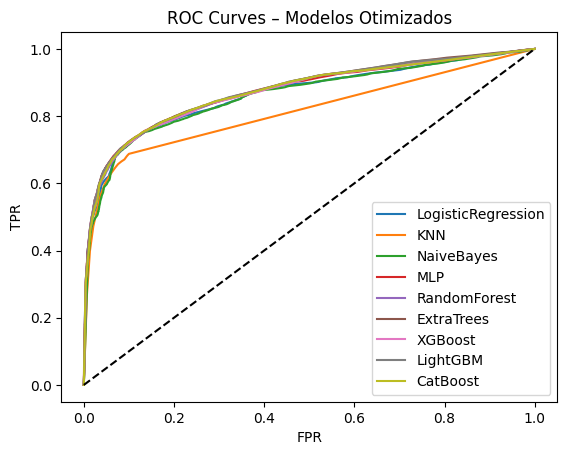

In [12]:
# 1) Instancie models_opt como antes

# 2) Avalie usando a função já definida em “3. Funções”
#    (não precisa definir evaluate_models_fast de novo)
metrics_opt, roc_curves_opt = evaluate_models(models_opt, X, y, cv=10)

# 3) Exiba a tabela de métricas
from IPython.display import display
print("### Métricas dos Modelos Otimizados")
display(metrics_opt)

# 4) Plote as curvas ROC comparativas inline
import matplotlib.pyplot as plt

plt.figure()
for name, (fpr, tpr) in roc_curves_opt.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves – Modelos Otimizados")
plt.legend()
plt.show()

[LightGBM] [Info] Number of positive: 27000, number of negative: 27000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 27000, number of negative: 27000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 27000, number of negative: 27000
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

,model,accuracy,precision,recall,f1,roc_auc,mutual_info
0,LogisticRegression,0.807983,0.879648,0.713600,0.787971,0.865188,0.215849
1,SVM_RBF,0.809450,0.853509,0.747133,0.796786,NaN,0.211122
2,KNN,0.785567,0.910218,0.633633,0.747150,0.814321,0.200849
3,NaiveBayes,0.774533,0.920033,0.601333,0.727302,0.861265,0.193088
4,MLP,0.811633,0.874499,0.727700,0.794374,0.873968,0.218866
5,RandomForest,0.809067,0.852735,0.747167,0.796468,0.873450,0.210479
6,ExtraTrees,0.810483,0.865604,0.735100,0.795032,0.875442,0.215143
7,XGBoost,0.810017,0.851878,0.750533,0.798001,0.871778,0.211512
8,LightGBM,0.812050,0.876433,0.726533,0.794474,0.875381,0.219912
9,CatBoost,0.811583,0.864524,0.738967,0.796830,0.872983,0.216260



### Melhores Modelos por Métrica ###
  • accuracy: LightGBM
  • precision: NaiveBayes
  • recall: XGBoost
  • f1: XGBoost
  • roc_auc: ExtraTrees
  • mutual_info: LightGBM


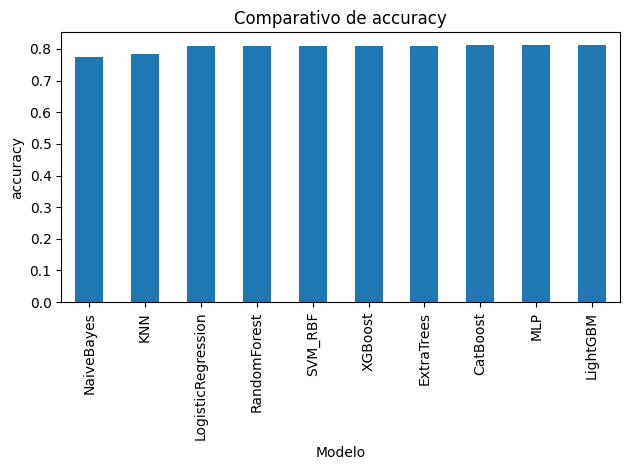

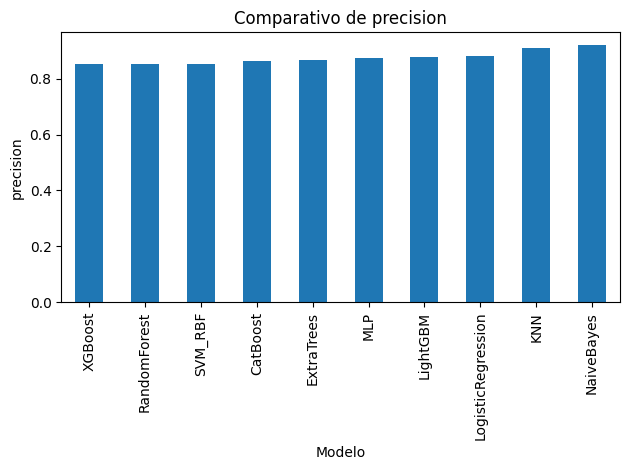

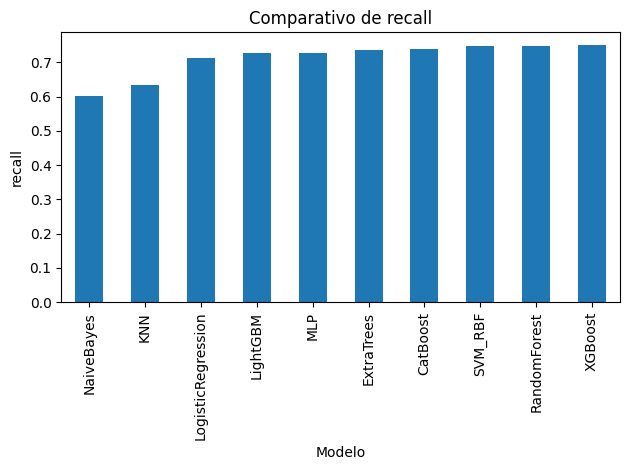

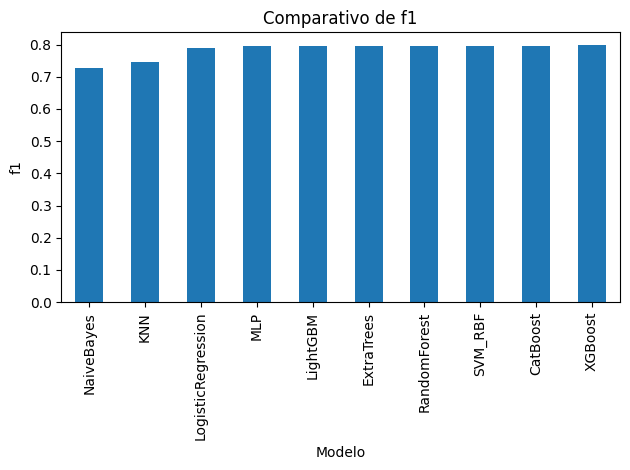

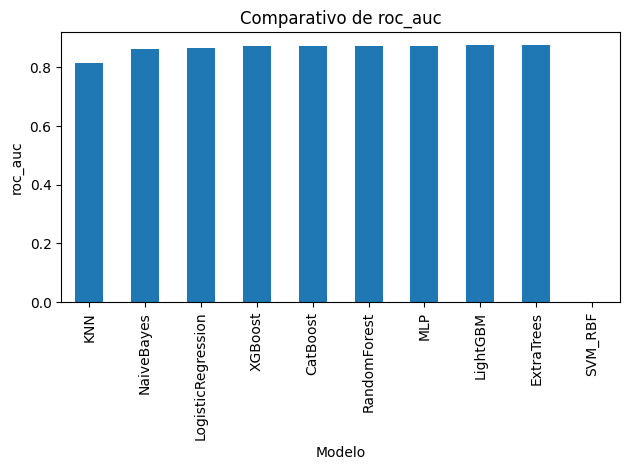

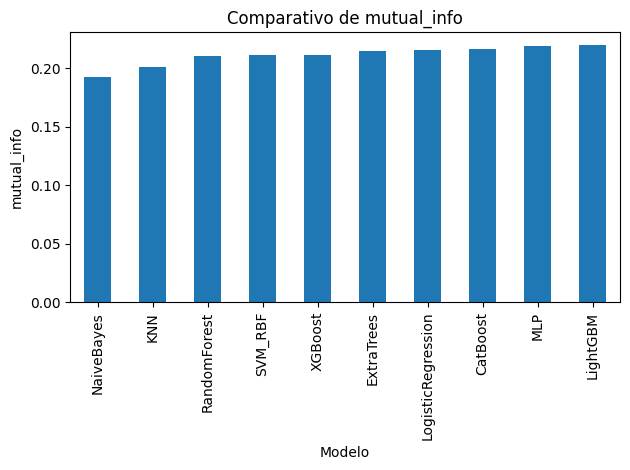

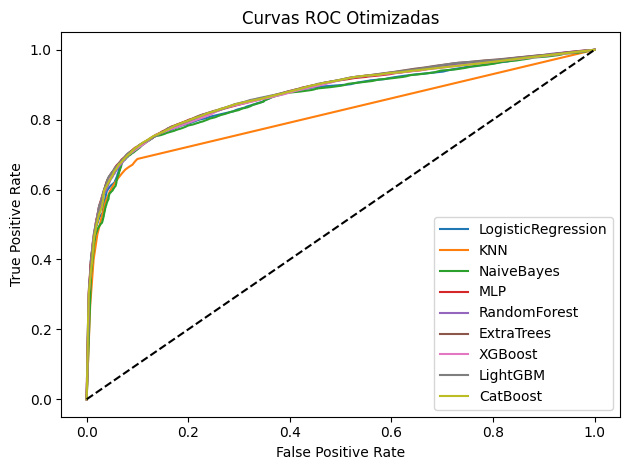

In [14]:
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# 1) Mapeamento de nomes para classes
_model_classes = {
    "LogisticRegression": LogisticRegression,
    "SVM_RBF":            SVC,
    "KNN":                KNeighborsClassifier,
    "NaiveBayes":         GaussianNB,
    "MLP":                MLPClassifier,
    "RandomForest":       RandomForestClassifier,
    "ExtraTrees":         ExtraTreesClassifier,
    "XGBoost":            xgb.XGBClassifier,
    "LightGBM":           lgb.LGBMClassifier,
    "CatBoost":           CatBoostClassifier
}

def compare_optuna_models(best_params: dict, X, y, cv: int = 10):
    """
    Instancia e avalia todos os modelos cujos parâmetros estão em best_params,
    usando evaluate_models(X, y, cv), e plota/mostra:
      - tabela de métricas
      - melhor modelo por métrica
      - curvas ROC comparativas
      - gráficos de barras para cada métrica
    Retorna (metrics_df, roc_curves).
    """
    # 2) Instancia os modelos otimizados
    models_opt = {}
    for name, params in best_params.items():
        p = params.copy()
        # renomeia 'lr' → 'learning_rate' se houver
        if name in ("XGBoost", "LightGBM", "CatBoost"):
            lr = p.pop("lr", None)
            if lr is not None:
                p["learning_rate"] = lr
        # trata MLP
        if name == "MLP":
            h1 = p.pop("h1", 100)
            h2 = p.pop("h2", 100)
            lr_mlp = p.pop("lr", 1e-3)
            p["hidden_layer_sizes"]  = (h1, h2)
            p["learning_rate_init"] = lr_mlp
            p["max_iter"]           = 500
        # instancia
        cls = _model_classes[name]
        models_opt[name] = cls(**p)

    # 3) Avalia com sua função original
    metrics_df, roc_curves = evaluate_models(models_opt, X, y, cv=cv)

    # 4) Exibe a tabela de métricas
    print("### Tabela de Métricas Otimizadas ###")
    display(metrics_df)

    # 5) Melhor modelo por métrica
    best_per_metric = metrics_df.set_index("model").idxmax()
    print("\n### Melhores Modelos por Métrica ###")
    for metric, best_model in best_per_metric.items():
        print(f"  • {metric}: {best_model}")

    # 6) Gráficos de barras comparativos
    for metric in ["accuracy","precision","recall","f1","roc_auc","mutual_info"]:
        plt.figure()
        metrics_df.set_index("model")[metric].sort_values().plot.bar()
        plt.title(f"Comparativo de {metric}")
        plt.ylabel(metric)
        plt.xlabel("Modelo")
        plt.tight_layout()
        plt.show()

    # 7) Curvas ROC comparativas
    plt.figure()
    for name, (fpr, tpr) in roc_curves.items():
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1],"k--")
    plt.title("Curvas ROC Otimizadas")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return metrics_df, roc_curves

# === Uso ===
metrics_opt, roc_curves_opt = compare_optuna_models(best_params, X, y, cv=10)



11. Comparação de Modelos pré e pós-otimização

### Tabela Comparativa de Métricas Antes vs. Depois da Otimização


,accuracy_orig,precision_orig,recall_orig,f1_orig,roc_auc_orig,mutual_info_orig,accuracy_opt,precision_opt,recall_opt,f1_opt,roc_auc_opt,mutual_info_opt
model,,,,,,,,,,,,
LogisticRegression,0.807800,0.878971,0.713900,0.787882,0.864867,0.215431,0.807983,0.879648,0.713600,0.787971,0.865188,0.215849
SVM_RBF,0.808983,0.853811,0.745633,0.796064,0.845216,0.210595,0.809450,0.853509,0.747133,0.796786,NaN,0.211122
KNN,0.747583,0.929907,0.535533,0.679654,0.785241,0.170442,0.785567,0.910218,0.633633,0.747150,0.814321,0.200849
NaiveBayes,0.774533,0.920033,0.601333,0.727302,0.861265,0.193088,0.774533,0.920033,0.601333,0.727302,0.861265,0.193088
MLP,0.812333,0.872209,0.731900,0.795918,0.873716,0.219126,0.811633,0.874499,0.727700,0.794374,0.873968,0.218866
RandomForest,0.805233,0.878170,0.708800,0.784447,0.867054,0.212117,0.809067,0.852735,0.747167,0.796468,0.873450,0.210479
ExtraTrees,0.802483,0.881747,0.698667,0.779602,0.861815,0.209931,0.810483,0.865604,0.735100,0.795032,0.875442,0.215143
XGBoost,0.810467,0.876871,0.722367,0.792156,0.874914,0.218080,0.810017,0.851878,0.750533,0.798001,0.871778,0.211512
LightGBM,0.811383,0.875961,0.725500,0.793662,0.875795,0.218956,0.812050,0.876433,0.726533,0.794474,0.875381,0.219912


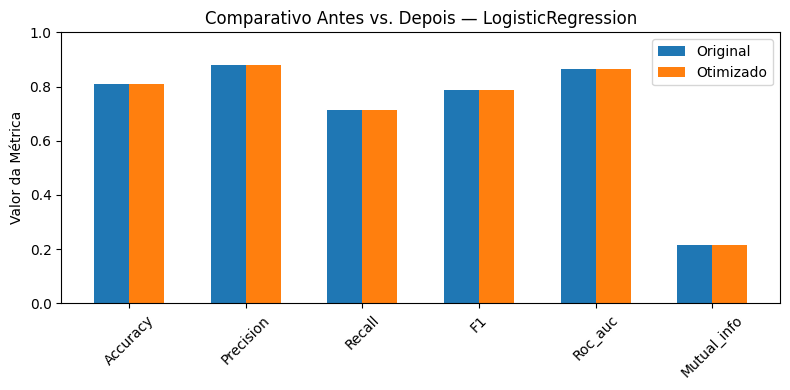

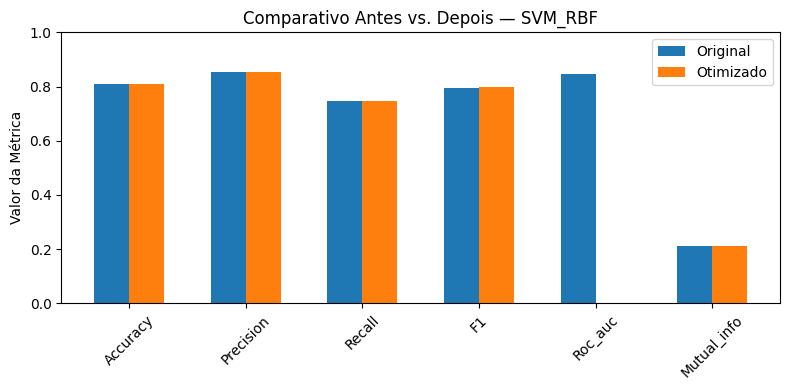

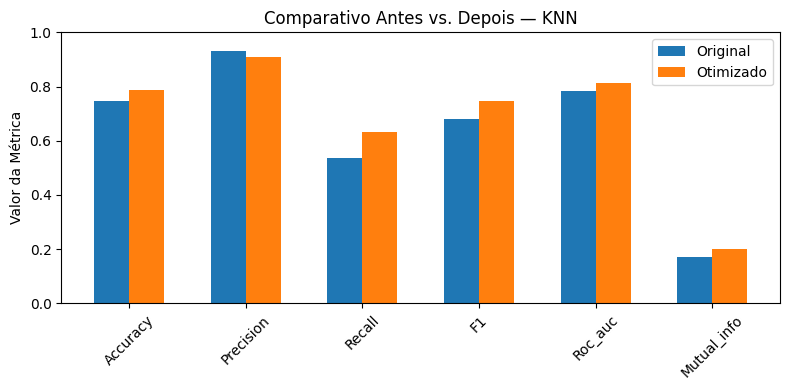

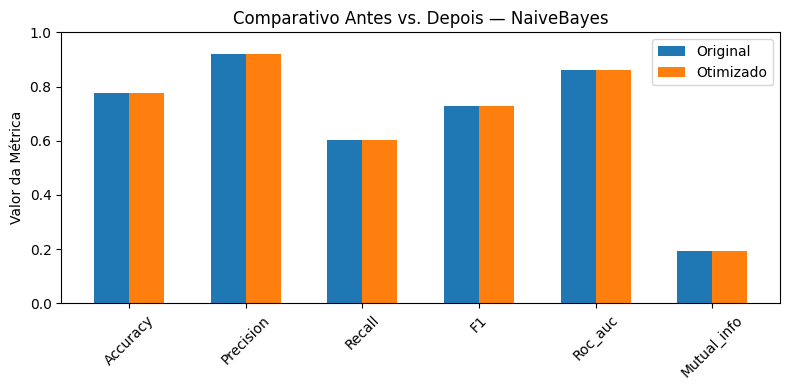

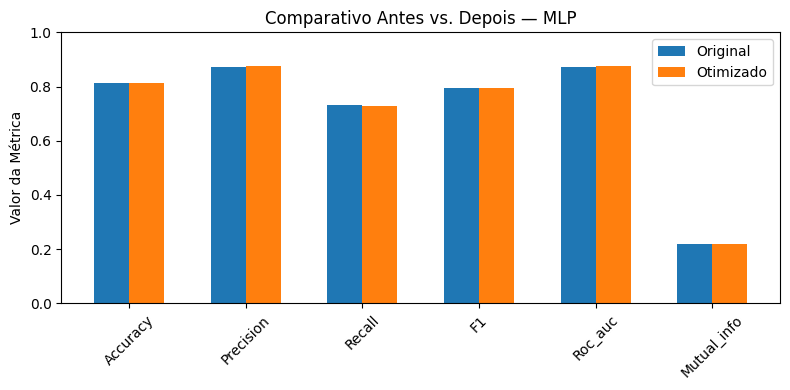

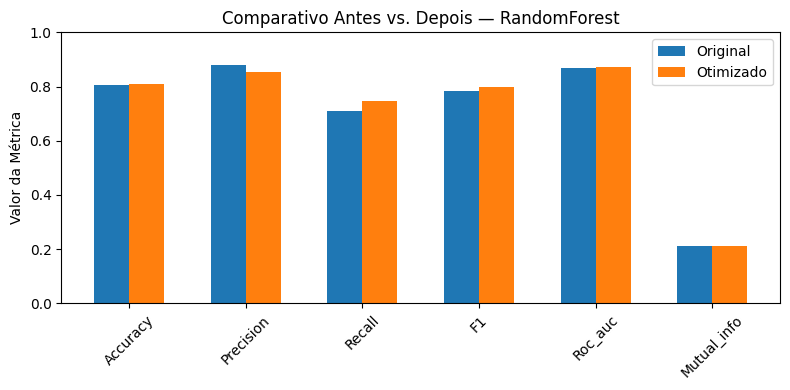

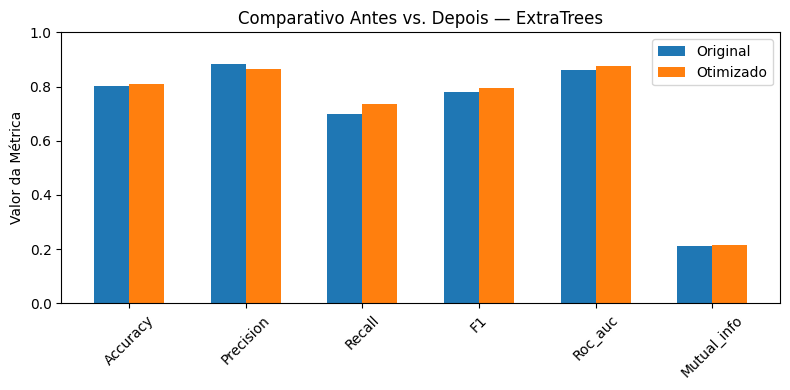

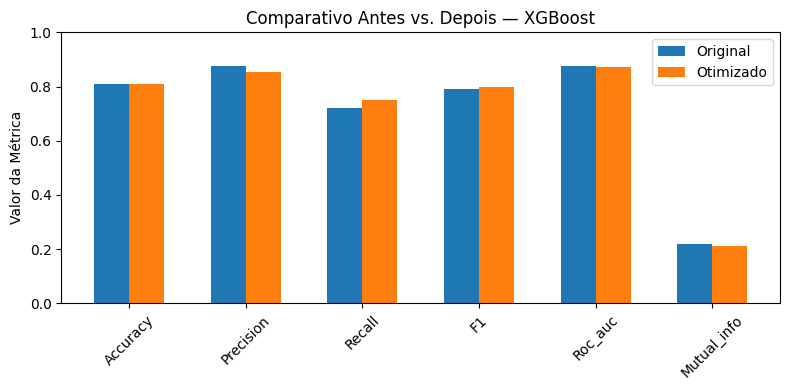

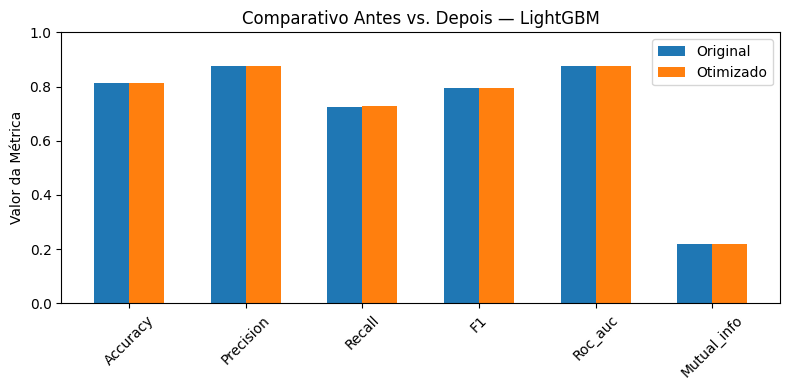

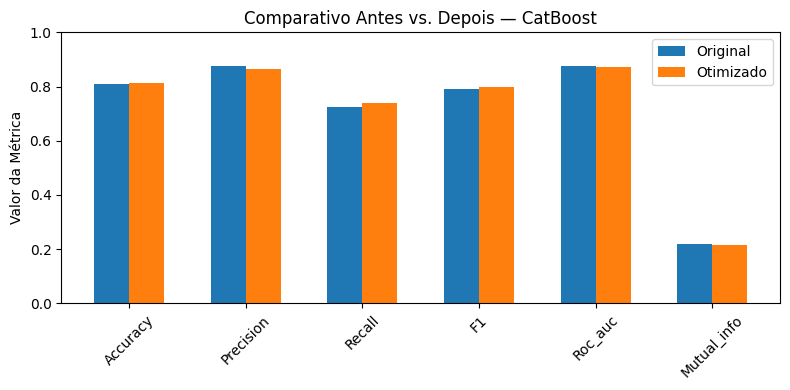

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Métricas antes e depois juntas em um único DataFrame
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc", "mutual_info"]

# Ajusta índices e junta
df_before = metrics_orig.set_index("model")[metrics]
df_after  = metrics_opt .set_index("model")[metrics]
df_compare = df_before.join(df_after, lsuffix="_orig", rsuffix="_opt")

print("### Tabela Comparativa de Métricas Antes vs. Depois da Otimização")
display(df_compare)

# 2) Gráfico por modelo comparando todas as métricas
for model in df_compare.index:
    # Para cada modelo, pegamos as seis métricas originais e otimizadas
    orig_vals = df_before.loc[model].values
    opt_vals  = df_after.loc[model].values

    x = range(len(metrics))
    plt.figure(figsize=(8, 4))
    plt.bar([i - 0.15 for i in x], orig_vals, width=0.3, label="Original")
    plt.bar([i + 0.15 for i in x], opt_vals,  width=0.3, label="Otimizado")
    plt.xticks(x, [m.capitalize() for m in metrics], rotation=45)
    plt.ylabel("Valor da Métrica")
    plt.ylim(0, 1)
    plt.title(f"Comparativo Antes vs. Depois — {model}")
    plt.legend()
    plt.tight_layout()
    plt.show()


12. Análise estatística dos Resultados: normalidade e teste estatístico adequado

In [16]:
from scipy.stats import shapiro, ttest_rel, wilcoxon

metrics = ["accuracy","precision","recall","f1","roc_auc","mutual_info"]

results = []
for m in metrics:
    diff = df_after[m] - df_before[m]  # df_before / df_after do código anterior

    # 1) Normalidade
    stat, p_norm = shapiro(diff)
    use_ttest = (p_norm > 0.05)

    if use_ttest:
        stat_test, pval = ttest_rel(df_after[m], df_before[m])
        test_name = "Paired t-test"
    else:
        stat_test, pval = wilcoxon(df_after[m], df_before[m])
        test_name = "Wilcoxon signed-rank"

    results.append({
        "metric": m,
        "normality_p": round(p_norm, 4),
        "test": test_name,
        "statistic": round(stat_test,4),
        "p_value": round(pval,4),
        "significant (α=0.05)": pval < 0.05
    })

import pandas as pd
res_df = pd.DataFrame(results).set_index("metric")
print("### Resultados dos testes pareados antes vs. depois")
display(res_df)


### Resultados dos testes pareados antes vs. depois


,normality_p,test,statistic,p_value,significant (α=0.05)
metric,,,,,
accuracy,0.0000,Wilcoxon signed-rank,7.0,0.0742,False
precision,0.0354,Wilcoxon signed-rank,9.0,0.1289,False
recall,0.0078,Wilcoxon signed-rank,5.0,0.0391,True
f1,0.0000,Wilcoxon signed-rank,4.0,0.0273,True
roc_auc,NaN,Wilcoxon signed-rank,NaN,NaN,False
mutual_info,0.0001,Wilcoxon signed-rank,20.0,0.8203,False


13. Melhor modelo e criação do pickle

In [17]:
# 1) Escolha da métrica de interesse
best_metric = "f1"   # pode ser "accuracy", "precision", "recall", "f1", "roc_auc" ou "mutual_info"

# 2) Identifica o índice do melhor modelo nessa métrica
best_idx   = metrics_opt[best_metric].idxmax()
best_name  = metrics_opt.loc[best_idx, "model"]
best_score = metrics_opt.loc[best_idx, best_metric]

print(f"Melhor modelo segundo {best_metric}: {best_name} (valor = {best_score:.4f})")

# 3) Recupera a instância otimizada correspondente
best_model = models_opt[best_name]

# 4) Ajusta o modelo em toda a base X,y
best_model.fit(X, y)

# 5) (Opcional) Salva o modelo para uso futuro
import joblib
os.makedirs("output/final_model", exist_ok=True)
joblib.dump(best_model, f"output/final_model/{best_name}.pkl")
print(f"Modelo salvo em output/final_model/{best_name}.pkl")

Melhor modelo segundo f1: XGBoost (valor = 0.7980)
Modelo salvo em output/final_model/XGBoost.pkl
